# **Home Credit Default Risk Prediction: Machine Learning Classification Model**

**Objective:**
To develop a machine learning model that predicts the probability of payment difficulties using applicant characteristics and credit history features, and to identify the most influential risk drivers affecting default risk.

In [ ]:
!pip install optuna
!pip install dalex
!pip install scikit-plot
!pip install shap
!pip install lime

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import dalex as dx
import shap
from lime.lime_tabular import LimeTabularExplainer
from scipy import stats
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report,accuracy_score

# Set the maximum number of columns and rows to display to a large number
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings('ignore')

## **Load Data**

In [ ]:
# read data

df = pd.read_csv('home_credit.csv')
df.sample()

SK_ID_CURR  TARGET  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
109750      209751     0.0          405000.0   1436850.0      46480.5   

        AMT_GOODS_PRICE  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_BIRTH  \
109750        1125000.0       0.33721      0.603226      0.781378      -13274   

        DAYS_EMPLOYED CODE_GENDER      NAME_INCOME_TYPE NAME_EDUCATION_TYPE  \
109750           -272           M  Commercial associate    Higher education   

       OCCUPATION_TYPE  CNT_CHILDREN  CNT_FAM_MEMBERS FLAG_OWN_CAR  \
109750      Core staff             2              4.0            N   

       FLAG_OWN_REALTY  OWN_CAR_AGE  REGION_RATING_CLIENT  \
109750               Y          NaN                     3   

        REGION_RATING_CLIENT_W_CITY  AMT_REQ_CREDIT_BUREAU_YEAR  \
109750                            3                         3.0   

        bureau_cnt_total  bureau_cnt_active  bureau_sum_debt  \
109750               7.0                5.0        1747696.5   

        bureau_sum_overdue  bureau_max_overdue_days  prev_cnt  \
109750                 0.0                      0.0       4.0   

        prev_cnt_approved  prev_cnt_refused  prev_avg_amt_credit  \
109750                1.0               0.0             862119.0   

        prev_avg_amt_annuity  prev_last_days_decision  inst_cnt  \
109750           23566.30957                   -152.0      29.0   

        inst_late_cnt  inst_late_days_avg  inst_late_days_max  \
109750           11.0           10.758621               130.0   

        inst_paid_ratio  pos_rows  pos_dpd_avg  pos_dpd_max  cc_rows  \
109750         0.810017      19.0     1.210526         23.0      NaN   

        cc_util_avg  cc_dpd_max  
109750          NaN         NaN

In [ ]:
df.info(max_cols=150, verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356255 entries, 0 to 356254
Data columns (total 45 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SK_ID_CURR                   356255 non-null  int64  
 1   TARGET                       307511 non-null  float64
 2   AMT_INCOME_TOTAL             356255 non-null  float64
 3   AMT_CREDIT                   356255 non-null  float64
 4   AMT_ANNUITY                  356219 non-null  float64
 5   AMT_GOODS_PRICE              355977 non-null  float64
 6   EXT_SOURCE_1                 162345 non-null  float64
 7   EXT_SOURCE_2                 355587 non-null  float64
 8   EXT_SOURCE_3                 286622 non-null  float64
 9   DAYS_BIRTH                   356255 non-null  int64  
 10  DAYS_EMPLOYED                356255 non-null  int64  
 11  CODE_GENDER                  356255 non-null  object 
 12  NAME_INCOME_TYPE             356255 non-null  object 
 13 

In [ ]:
#dropna di kolom target itu karena data tes yang tidak ada labelnya

df.dropna(subset=['TARGET'], inplace=True)

In [ ]:
df.info(max_cols=150, verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 307511 entries, 1 to 356254
Data columns (total 45 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SK_ID_CURR                   307511 non-null  int64  
 1   TARGET                       307511 non-null  float64
 2   AMT_INCOME_TOTAL             307511 non-null  float64
 3   AMT_CREDIT                   307511 non-null  float64
 4   AMT_ANNUITY                  307499 non-null  float64
 5   AMT_GOODS_PRICE              307233 non-null  float64
 6   EXT_SOURCE_1                 134133 non-null  float64
 7   EXT_SOURCE_2                 306851 non-null  float64
 8   EXT_SOURCE_3                 246546 non-null  float64
 9   DAYS_BIRTH                   307511 non-null  int64  
 10  DAYS_EMPLOYED                307511 non-null  int64  
 11  CODE_GENDER                  307511 non-null  object 
 12  NAME_INCOME_TYPE             307511 non-null  object 
 13  NAME

# **Data Cleaning Before Splitting**

In [ ]:
#Cek Duplicate

df.duplicated().sum()

np.int64(0)

Tidak ada duplicate

In [ ]:
#Cek Persentase Missing Value

column_names = df.columns.tolist()

for column in column_names:
    missing_percentage = (df[column].isna().sum() / len(df)) * 100
    print(f"{column}: {missing_percentage:.2f}%")

SK_ID_CURR: 0.00%
TARGET: 0.00%
AMT_INCOME_TOTAL: 0.00%
AMT_CREDIT: 0.00%
AMT_ANNUITY: 0.00%
AMT_GOODS_PRICE: 0.09%
EXT_SOURCE_1: 56.38%
EXT_SOURCE_2: 0.21%
EXT_SOURCE_3: 19.83%
DAYS_BIRTH: 0.00%
DAYS_EMPLOYED: 0.00%
CODE_GENDER: 0.00%
NAME_INCOME_TYPE: 0.00%
NAME_EDUCATION_TYPE: 0.00%
OCCUPATION_TYPE: 31.35%
CNT_CHILDREN: 0.00%
CNT_FAM_MEMBERS: 0.00%
FLAG_OWN_CAR: 0.00%
FLAG_OWN_REALTY: 0.00%
OWN_CAR_AGE: 65.99%
REGION_RATING_CLIENT: 0.00%
REGION_RATING_CLIENT_W_CITY: 0.00%
AMT_REQ_CREDIT_BUREAU_YEAR: 13.50%
bureau_cnt_total: 14.31%
bureau_cnt_active: 14.31%
bureau_sum_debt: 14.31%
bureau_sum_overdue: 14.31%
bureau_max_overdue_days: 14.31%
prev_cnt: 5.35%
prev_cnt_approved: 5.35%
prev_cnt_refused: 5.35%
prev_avg_amt_credit: 5.35%
prev_avg_amt_annuity: 5.35%
prev_last_days_decision: 5.35%
inst_cnt: 5.89%
inst_late_cnt: 5.89%
inst_late_days_avg: 5.89%
inst_late_days_max: 5.89%
inst_paid_ratio: 5.89%
pos_rows: 6.68%
pos_dpd_avg: 6.68%
pos_dpd_max: 6.68%
cc_rows: 74.66%
cc_util_avg: 74.94

Kolom yang memiliki missing value lebih dari 20% didrop yaitu kolom cc_*, occupation_type, own car age

In [ ]:
#drop kolom

df = df.drop(columns=['cc_rows', 'cc_util_avg', 'cc_dpd_max', 'OCCUPATION_TYPE', 'OWN_CAR_AGE'])

In [ ]:
#membuat col median ext

cols = ["EXT_SOURCE_1","EXT_SOURCE_2","EXT_SOURCE_3"]

df["ext_median"] = df[cols].median(axis=1, skipna=True)

In [ ]:
#drop kolom ext 123
df = df.drop(columns=['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3'])

In [ ]:
#UBAH DATA DAYS MENJADI TAHUN

df["age_years"] = (-df["DAYS_BIRTH"] / 365.25).round(2)

# DAYS_EMPLOYED kadang ada nilai aneh 365243 (kode khusus = missing)
df["DAYS_EMPLOYED"] = df["DAYS_EMPLOYED"].replace(365243, np.nan)
df["employed_years"] = (-df["DAYS_EMPLOYED"] / 365.25).round(2)

In [ ]:
#DROP KOLOM DAYS

df = df.drop(columns=['DAYS_BIRTH','DAYS_EMPLOYED'])

In [ ]:
# CEK data info
df.info(max_cols=150, verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 307511 entries, 1 to 356254
Data columns (total 38 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SK_ID_CURR                   307511 non-null  int64  
 1   TARGET                       307511 non-null  float64
 2   AMT_INCOME_TOTAL             307511 non-null  float64
 3   AMT_CREDIT                   307511 non-null  float64
 4   AMT_ANNUITY                  307499 non-null  float64
 5   AMT_GOODS_PRICE              307233 non-null  float64
 6   CODE_GENDER                  307511 non-null  object 
 7   NAME_INCOME_TYPE             307511 non-null  object 
 8   NAME_EDUCATION_TYPE          307511 non-null  object 
 9   CNT_CHILDREN                 307511 non-null  int64  
 10  CNT_FAM_MEMBERS              307509 non-null  float64
 11  FLAG_OWN_CAR                 307511 non-null  object 
 12  FLAG_OWN_REALTY              307511 non-null  object 
 13  REGI

In [ ]:
#cek missing value dan NAN
column_names = df.columns.tolist()

for column in column_names:
    missing_percentage = (df[column].isna().sum() / len(df)) * 100
    print(f"{column}: {missing_percentage:.2f}%")

SK_ID_CURR: 0.00%
TARGET: 0.00%
AMT_INCOME_TOTAL: 0.00%
AMT_CREDIT: 0.00%
AMT_ANNUITY: 0.00%
AMT_GOODS_PRICE: 0.09%
CODE_GENDER: 0.00%
NAME_INCOME_TYPE: 0.00%
NAME_EDUCATION_TYPE: 0.00%
CNT_CHILDREN: 0.00%
CNT_FAM_MEMBERS: 0.00%
FLAG_OWN_CAR: 0.00%
FLAG_OWN_REALTY: 0.00%
REGION_RATING_CLIENT: 0.00%
REGION_RATING_CLIENT_W_CITY: 0.00%
AMT_REQ_CREDIT_BUREAU_YEAR: 13.50%
bureau_cnt_total: 14.31%
bureau_cnt_active: 14.31%
bureau_sum_debt: 14.31%
bureau_sum_overdue: 14.31%
bureau_max_overdue_days: 14.31%
prev_cnt: 5.35%
prev_cnt_approved: 5.35%
prev_cnt_refused: 5.35%
prev_avg_amt_credit: 5.35%
prev_avg_amt_annuity: 5.35%
prev_last_days_decision: 5.35%
inst_cnt: 5.89%
inst_late_cnt: 5.89%
inst_late_days_avg: 5.89%
inst_late_days_max: 5.89%
inst_paid_ratio: 5.89%
pos_rows: 6.68%
pos_dpd_avg: 6.68%
pos_dpd_max: 6.68%
ext_median: 0.06%
age_years: 0.00%
employed_years: 18.01%


In [ ]:
#Cek nilai-nilai di kolom kategorikal

categorical_column = df.select_dtypes(include=['object']).columns

for column in categorical_column:
    print(f"============= {column} =================")
    display(df[column].value_counts())
    print()

============= CODE_GENDER =================


CODE_GENDER
F      202448
M      105059
XNA         4
Name: count, dtype: int64


============= NAME_INCOME_TYPE =================


NAME_INCOME_TYPE
Working                 158774
Commercial associate     71617
Pensioner                55362
State servant            21703
Unemployed                  22
Student                     18
Businessman                 10
Maternity leave              5
Name: count, dtype: int64


============= NAME_EDUCATION_TYPE =================


NAME_EDUCATION_TYPE
Secondary / secondary special    218391
Higher education                  74863
Incomplete higher                 10277
Lower secondary                    3816
Academic degree                     164
Name: count, dtype: int64


============= FLAG_OWN_CAR =================


FLAG_OWN_CAR
N    202924
Y    104587
Name: count, dtype: int64


============= FLAG_OWN_REALTY =================


FLAG_OWN_REALTY
Y    213312
N     94199
Name: count, dtype: int64

In [ ]:
#drop value xna di kolom gender

df = df[df['CODE_GENDER'] != 'XNA']

In [ ]:
# GANTI VALUE TARGET 1 = BERMASALAH 0= AMAN

df['TARGET'] = df['TARGET'].replace({1: 'Bermasalah', 0: 'Aman'})

In [ ]:
#drop kolom sk id

df = df.drop(columns=['SK_ID_CURR'])

## **Exploratory data Analysis**

In [ ]:
#copy dataset untuk EDA

df_eda = df.copy()

In [ ]:
#cek duplicate

df_eda.duplicated().sum()

np.int64(0)

In [ ]:
#cek missing Value

df_eda.isna().sum()

TARGET                             0
AMT_INCOME_TOTAL                   0
AMT_CREDIT                         0
AMT_ANNUITY                       12
AMT_GOODS_PRICE                  278
CODE_GENDER                        0
NAME_INCOME_TYPE                   0
NAME_EDUCATION_TYPE                0
CNT_CHILDREN                       0
CNT_FAM_MEMBERS                    2
FLAG_OWN_CAR                       0
FLAG_OWN_REALTY                    0
REGION_RATING_CLIENT               0
REGION_RATING_CLIENT_W_CITY        0
AMT_REQ_CREDIT_BUREAU_YEAR     41519
bureau_cnt_total               44020
bureau_cnt_active              44020
bureau_sum_debt                44020
bureau_sum_overdue             44020
bureau_max_overdue_days        44020
prev_cnt                       16454
prev_cnt_approved              16454
prev_cnt_refused               16454
prev_avg_amt_credit            16454
prev_avg_amt_annuity           16454
prev_last_days_decision        16454
inst_cnt                       18105
inst_late_cnt                  18105
inst_late_days_avg             18105
inst_late_days_max             18105
inst_paid_ratio                18107
pos_rows                       20544
pos_dpd_avg                    20544
pos_dpd_max                    20544
ext_median                       172
age_years                          0
employed_years                 55374
dtype: int64

In [ ]:
#handling missing value courier experience dengan median

missing_value_columns = df_eda.columns[df_eda.isna().any()].tolist()

for column in missing_value_columns:
    df_eda[column] = df_eda[column].fillna(df_eda[column].median())

In [ ]:
df_eda.isna().sum()

TARGET                         0
AMT_INCOME_TOTAL               0
AMT_CREDIT                     0
AMT_ANNUITY                    0
AMT_GOODS_PRICE                0
CODE_GENDER                    0
NAME_INCOME_TYPE               0
NAME_EDUCATION_TYPE            0
CNT_CHILDREN                   0
CNT_FAM_MEMBERS                0
FLAG_OWN_CAR                   0
FLAG_OWN_REALTY                0
REGION_RATING_CLIENT           0
REGION_RATING_CLIENT_W_CITY    0
AMT_REQ_CREDIT_BUREAU_YEAR     0
bureau_cnt_total               0
bureau_cnt_active              0
bureau_sum_debt                0
bureau_sum_overdue             0
bureau_max_overdue_days        0
prev_cnt                       0
prev_cnt_approved              0
prev_cnt_refused               0
prev_avg_amt_credit            0
prev_avg_amt_annuity           0
prev_last_days_decision        0
inst_cnt                       0
inst_late_cnt                  0
inst_late_days_avg             0
inst_late_days_max             0
inst_paid_ratio                0
pos_rows                       0
pos_dpd_avg                    0
pos_dpd_max                    0
ext_median                     0
age_years                      0
employed_years                 0
dtype: int64

In [ ]:
df_eda.describe()

AMT_INCOME_TOTAL    AMT_CREDIT    AMT_ANNUITY  AMT_GOODS_PRICE  \
count      3.075070e+05  3.075070e+05  307507.000000     3.075070e+05   
mean       1.687977e+05  5.990286e+05   27108.580714     5.383178e+05   
std        2.371246e+05  4.024926e+05   14493.522125     3.692898e+05   
min        2.565000e+04  4.500000e+04    1615.500000     4.050000e+04   
25%        1.125000e+05  2.700000e+05   16524.000000     2.385000e+05   
50%        1.471500e+05  5.135310e+05   24903.000000     4.500000e+05   
75%        2.025000e+05  8.086500e+05   34596.000000     6.795000e+05   
max        1.170000e+08  4.050000e+06  258025.500000     4.050000e+06   

        CNT_CHILDREN  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
count  307507.000000    307507.000000         307507.000000   
mean        0.417047         2.152657              2.052461   
std         0.722119         0.910677              0.509034   
min         0.000000         1.000000              1.000000   
25%         0.000000         2.000000              2.000000   
50%         0.000000         2.000000              2.000000   
75%         1.000000         3.000000              2.000000   
max        19.000000        20.000000              3.000000   

       REGION_RATING_CLIENT_W_CITY  AMT_REQ_CREDIT_BUREAU_YEAR  \
count                307507.000000               307507.000000   
mean                      2.031518                    1.778441   
std                       0.502737                    1.765512   
min                       1.000000                    0.000000   
25%                       2.000000                    1.000000   
50%                       2.000000                    1.000000   
75%                       2.000000                    3.000000   
max                       3.000000                   25.000000   

       bureau_cnt_total  bureau_cnt_active  bureau_sum_debt  \
count      307507.00000      307507.000000     3.075070e+05   
mean            5.33767           2.048555     5.731282e+05   
std             4.08918           1.655047     1.521492e+06   
min             1.00000           0.000000    -6.981558e+06   
25%             3.00000           1.000000     0.000000e+00   
50%             4.00000           2.000000     1.690155e+05   
75%             7.00000           3.000000     5.348520e+05   
max           116.00000          32.000000     3.344983e+08   

       bureau_sum_overdue  bureau_max_overdue_days       prev_cnt  \
count        3.075070e+05            307507.000000  307507.000000   
mean         1.910633e+02                 4.089539       4.811149   
std          1.527110e+04                82.532154       4.038983   
min          0.000000e+00                 0.000000       1.000000   
25%          0.000000e+00                 0.000000       2.000000   
50%          0.000000e+00                 0.000000       4.000000   
75%          0.000000e+00                 0.000000       6.000000   
max          3.756681e+06              2792.000000      73.000000   

       prev_cnt_approved  prev_cnt_refused  prev_avg_amt_credit  \
count      307507.000000     307507.000000         3.075070e+05   
mean            3.042006          0.797917         1.672533e+05   
std             2.066955          1.774689         1.616771e+05   
min             0.000000          0.000000         0.000000e+00   
25%             1.000000          0.000000         6.915568e+04   
50%             3.000000          0.000000         1.174500e+05   
75%             4.000000          1.000000         2.074392e+05   
max            27.000000         68.000000         4.050000e+06   

       prev_avg_amt_annuity  prev_last_days_decision       inst_cnt  \
count         307507.000000             307507.00000  307507.000000   
mean           11955.503064               -471.09163      35.792688   
std             8471.419862                527.12852      34.969089   
min                0.000000              -2922.00000       1.000000   
25%             6626.399984          

In [ ]:
df_eda.describe(include='object')

TARGET CODE_GENDER NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
count   307507      307507           307507                         307507   
unique       2           2                8                              5   
top       Aman           F          Working  Secondary / secondary special   
freq    282682      202448           158771                         218389   

       FLAG_OWN_CAR FLAG_OWN_REALTY  
count        307507          307507  
unique            2               2  
top               N               Y  
freq         202922          213308

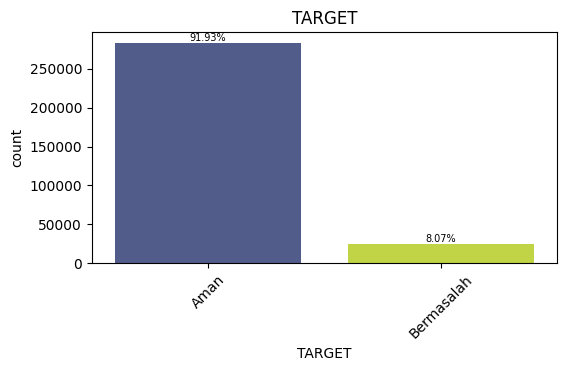

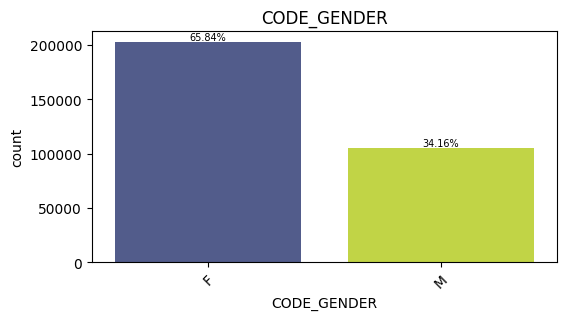

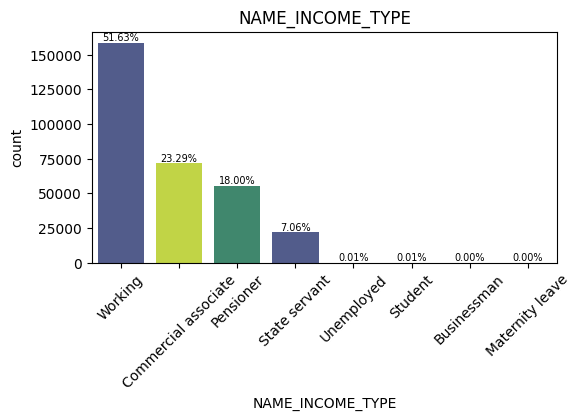

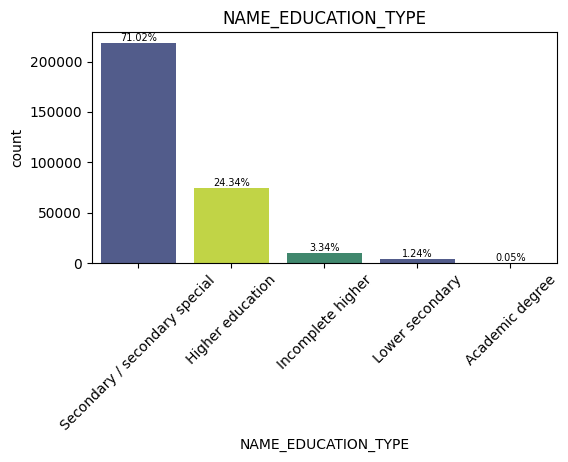

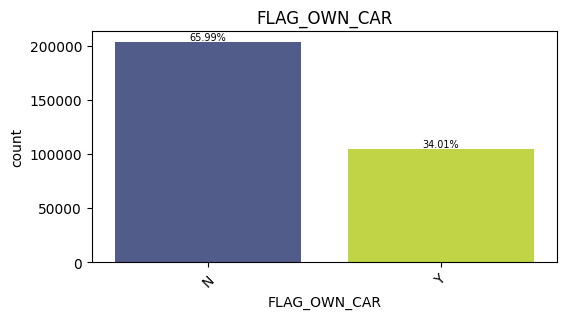

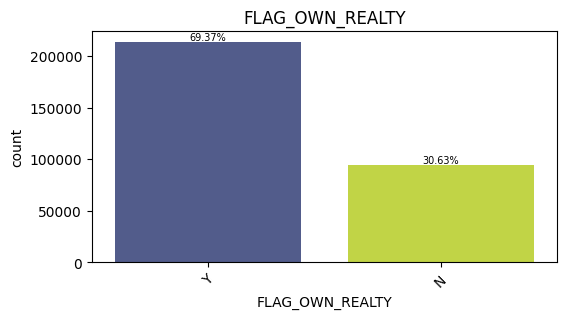

In [ ]:
kolom_kategorik = df_eda.select_dtypes(include=['object']).columns
palette = ['#485695', '#d2ec2e', '#349370']
for col in kolom_kategorik:
    plt.figure(figsize=(6,3))
    #mengurutkan kategori berdasarkan presentase
    order = df_eda[col].value_counts().index

    ax = sns.countplot(x=df_eda[col],order=order, palette= palette)
    plt.title(f'{col}')
    plt.xticks(rotation=45)

    total = len(df_eda)

    for p in ax.patches:
        percent = 100 * p.get_height() / total
        ax.annotate(f'{percent:.2f}%', (p.get_x() + p.get_width() / 2, p.get_height()),
                    ha='center', va='bottom', fontsize=7, color='black')
    plt.show()

Target distribution is highly imbalanced (Safe 91.93% vs Payment Difficulty 8.07%), so AUPRC is a more appropriate metric than accuracy or ROC-AUC because it focuses on performance for the minority (positive) class.

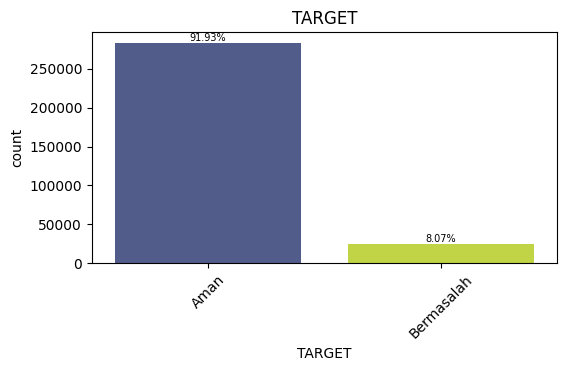

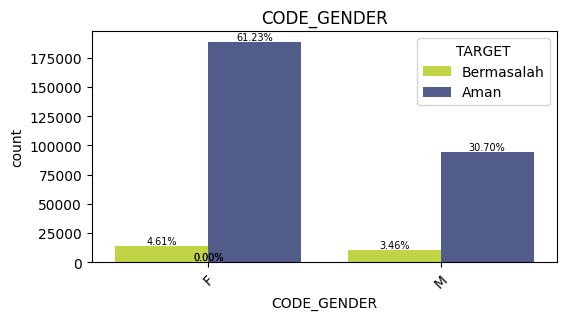

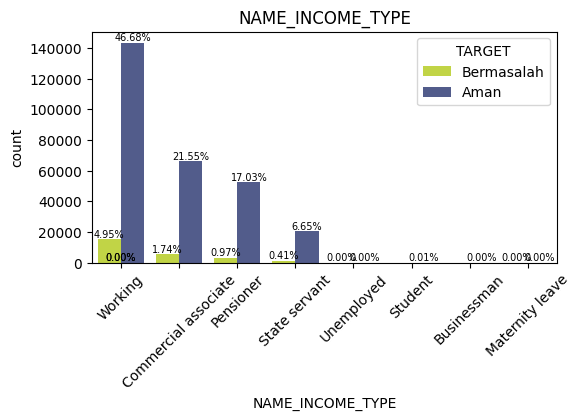

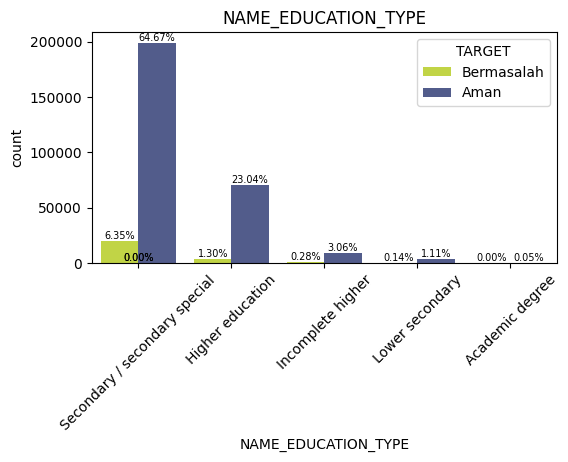

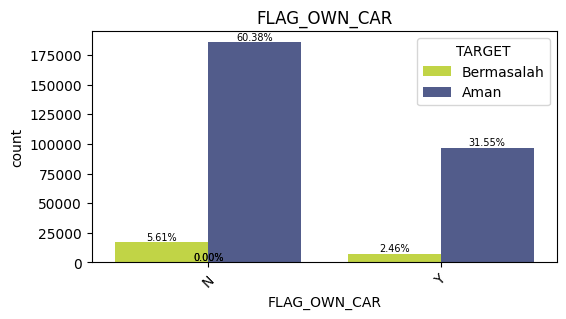

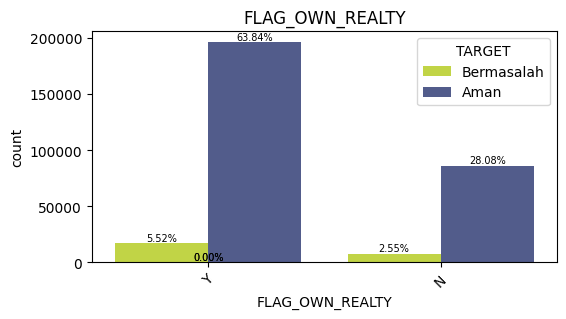

In [ ]:
palette = ['#d2ec2e','#485695']
for col in kolom_kategorik:
    plt.figure(figsize=(6,3))
    #mengurutkan kategori berdasarkan presentase
    order = df_eda[col].value_counts().index

    ax = sns.countplot(x=df_eda[col], hue=df_eda['TARGET'], order=order, palette=palette)
    plt.title(f'{col}')
    plt.xticks(rotation=45)

    total = len(df_eda)

    for p in ax.patches:
        percent = 100 * p.get_height() / total
        ax.annotate(f'{percent:.2f}%', (p.get_x() + p.get_width() / 2, p.get_height()),
                    ha='center', va='bottom', fontsize=7, color='black')
    plt.show()

P-value AMT_INCOME_TOTAL vs target: 0.00


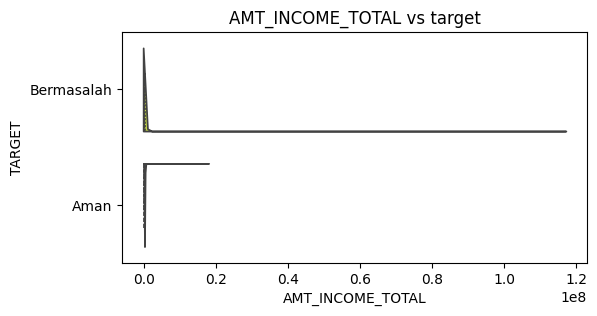

P-value AMT_CREDIT vs target: 0.00


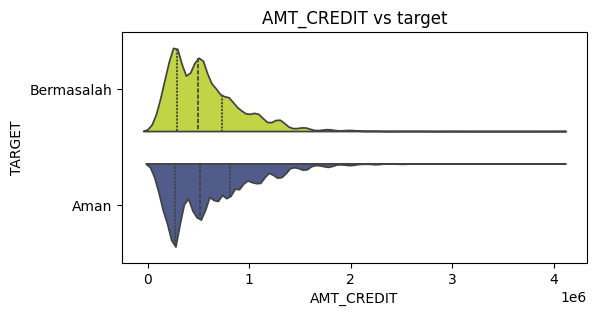

P-value AMT_ANNUITY vs target: 0.97


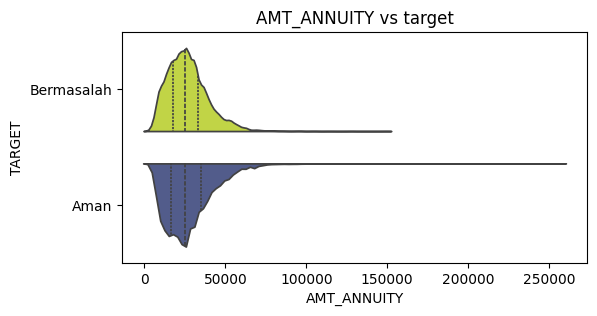

P-value AMT_GOODS_PRICE vs target: 0.00


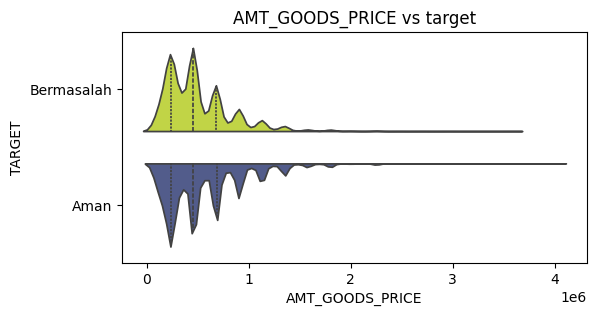

P-value CNT_CHILDREN vs target: 0.00


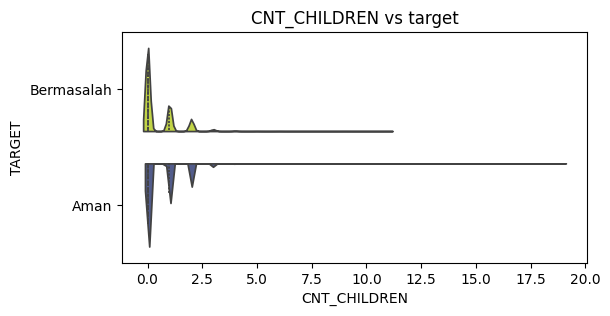

P-value CNT_FAM_MEMBERS vs target: 0.00


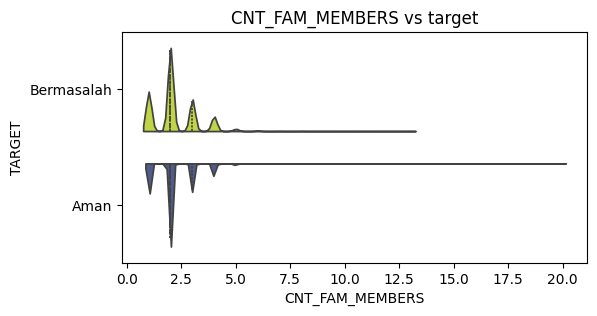

P-value REGION_RATING_CLIENT vs target: 0.00


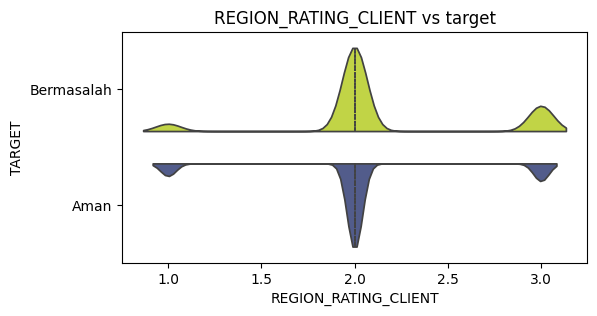

P-value REGION_RATING_CLIENT_W_CITY vs target: 0.00


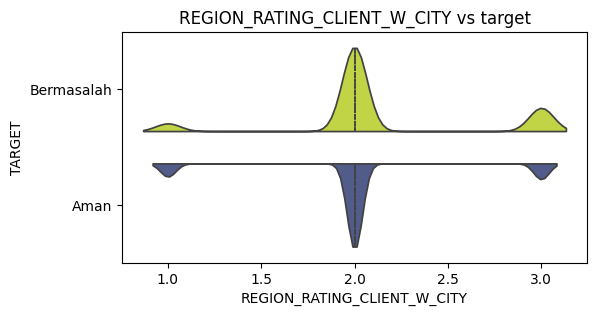

P-value AMT_REQ_CREDIT_BUREAU_YEAR vs target: 0.00


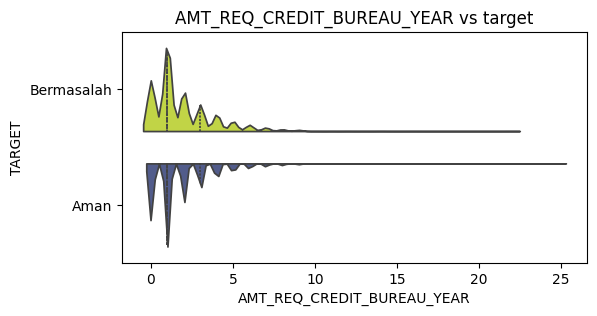

P-value bureau_cnt_total vs target: 0.00


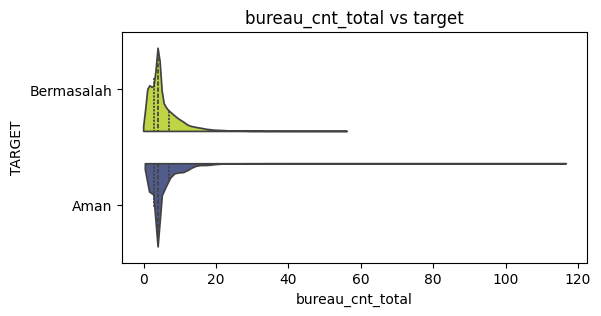

P-value bureau_cnt_active vs target: 0.00


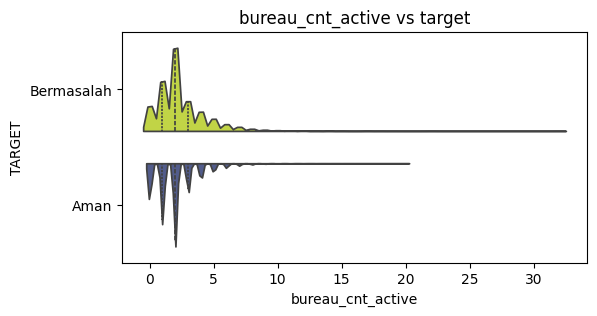

P-value bureau_sum_debt vs target: 0.00


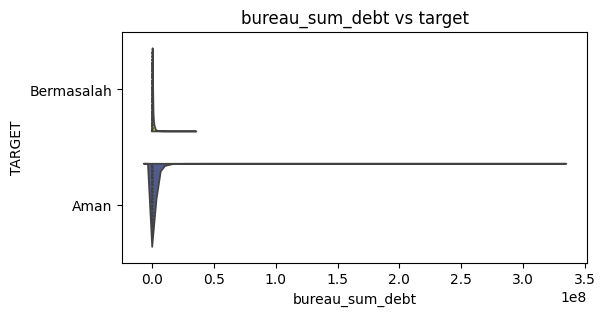

P-value bureau_sum_overdue vs target: 0.00


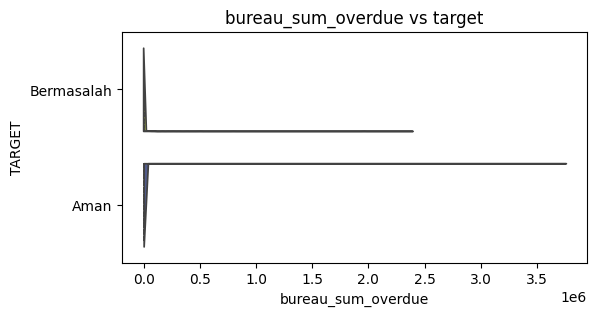

P-value bureau_max_overdue_days vs target: 0.00


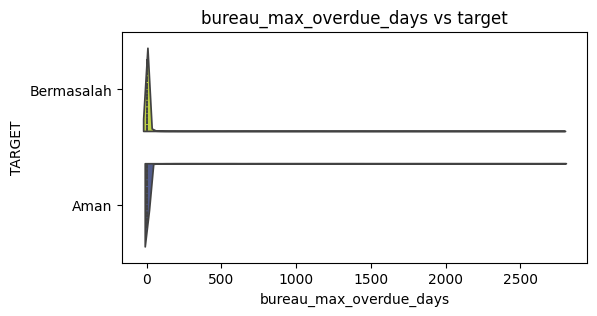

P-value prev_cnt vs target: 0.00


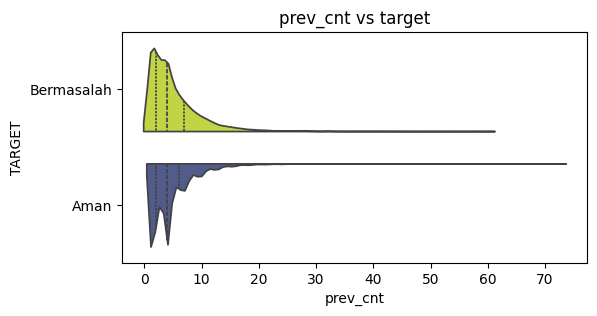

P-value prev_cnt_approved vs target: 0.00


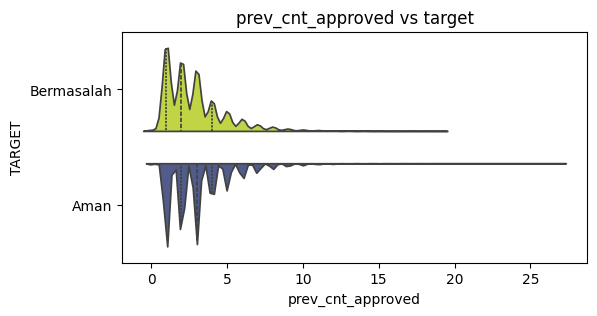

P-value prev_cnt_refused vs target: 0.00


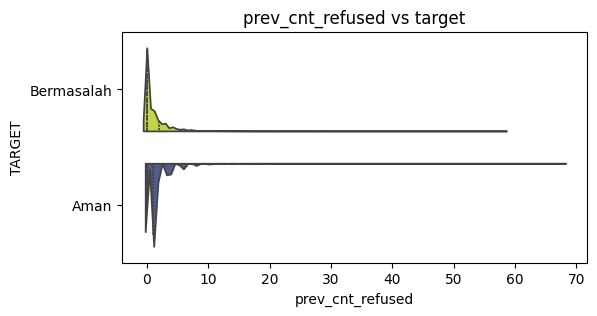

P-value prev_avg_amt_credit vs target: 0.00


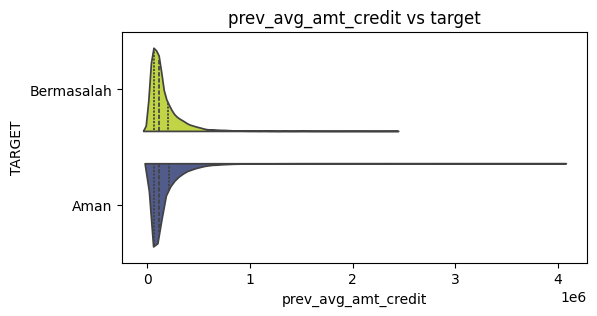

P-value prev_avg_amt_annuity vs target: 0.00


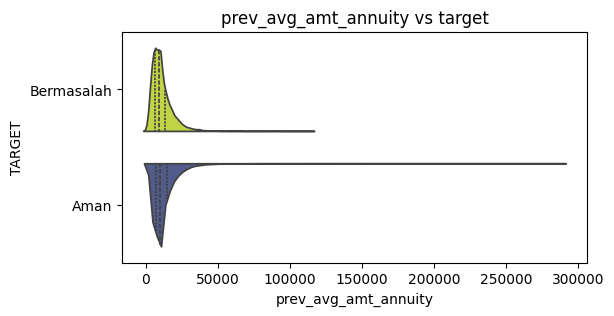

P-value prev_last_days_decision vs target: 0.00


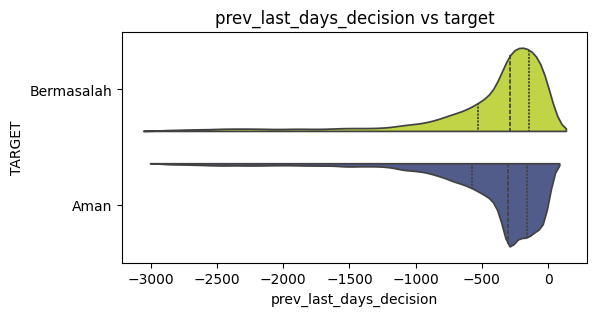

P-value inst_cnt vs target: 0.00


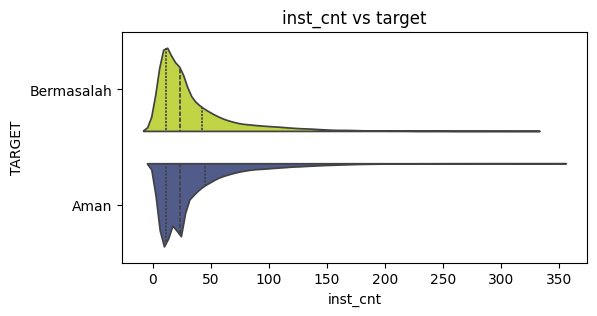

P-value inst_late_cnt vs target: 0.00


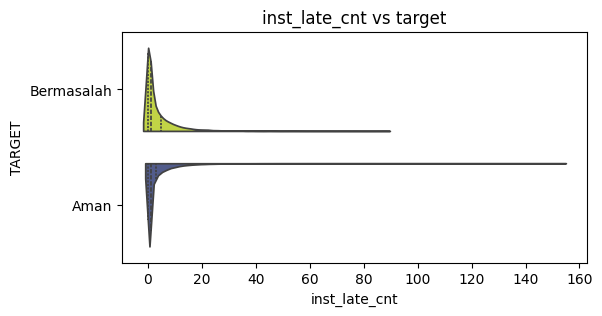

P-value inst_late_days_avg vs target: 0.00


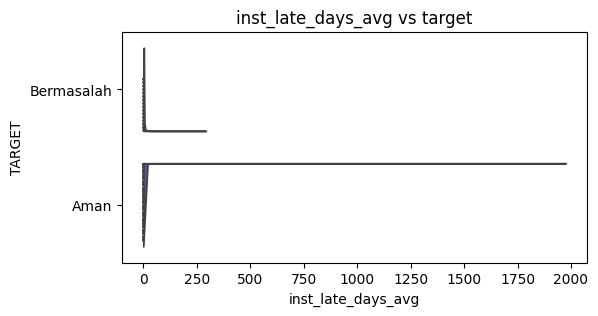

P-value inst_late_days_max vs target: 0.00


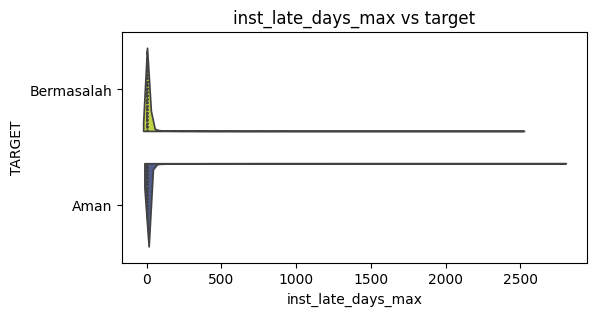

P-value inst_paid_ratio vs target: 0.00


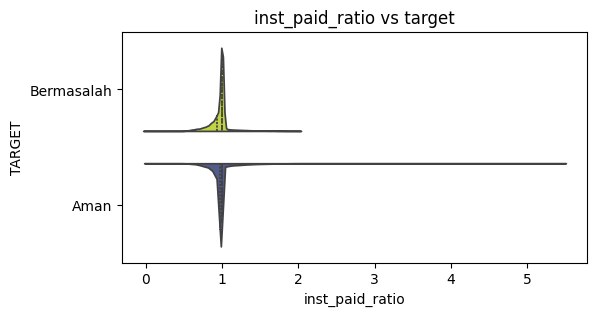

P-value pos_rows vs target: 0.00


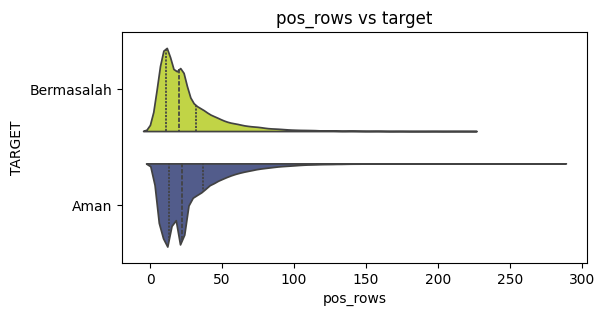

P-value pos_dpd_avg vs target: 0.00


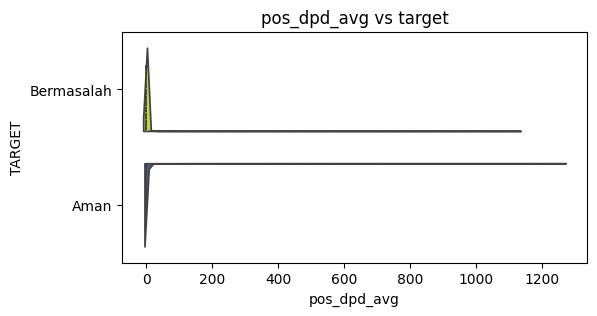

P-value pos_dpd_max vs target: 0.00


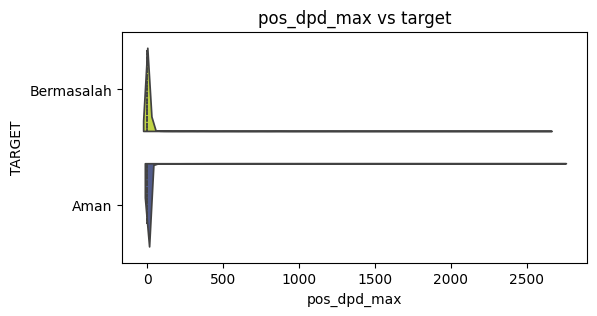

P-value ext_median vs target: 0.00


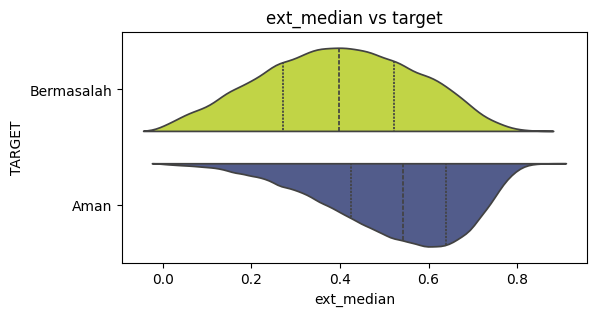

P-value age_years vs target: 0.00


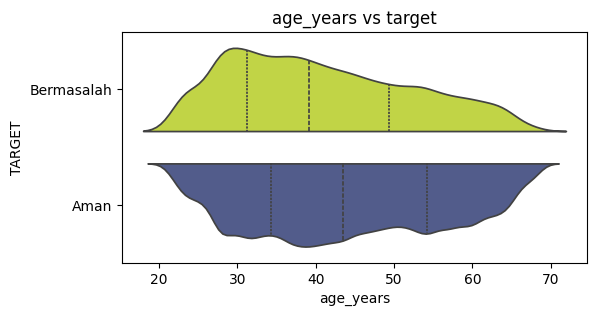

P-value employed_years vs target: 0.00


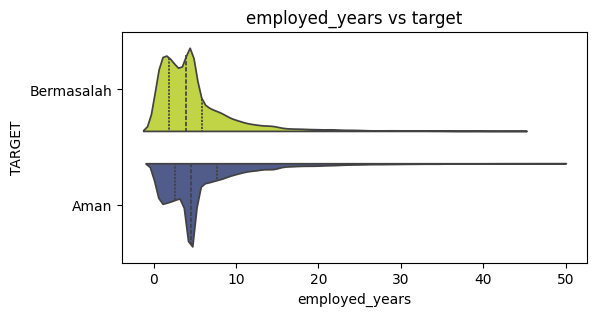

In [ ]:
#Violin plot numeric vs categoric
from scipy.stats import mannwhitneyu

numeric_column = df_eda.select_dtypes(include=['int64', 'float64']).columns

for col in numeric_column:
    safe = df_eda[df_eda['TARGET'] == 'Aman'][col]
    not_safe = df_eda[df_eda['TARGET'] == 'Bermasalah'][col]
    res = mannwhitneyu(safe, not_safe, alternative = 'two-sided')
    print(f'P-value {col} vs target: {res.pvalue:.2f}')

    plt.figure(figsize=(6,3))
    sns.violinplot(data = df_eda,
    x = col,
    y = 'TARGET', # Corrected from 'target' to 'TARGET'
    split = True,
    inner = 'quart',
    gap = 0.1,
    palette = palette)


    plt.title(f'{col} vs target')
    plt.show()

ext_median is the median of three external risk scores (EXT_SOURCE_1/2/3), providing a robust combined signal that is less sensitive to outliers or missing values from a single source.
The violin plot suggests lower ext_median values are associated with higher payment-difficulty risk, and the Mann–Whitney U test (p < 0.001) confirms a statistically significant difference between the two classes.


## **Split Train and Test**

In [ ]:
#split train dan test

df_pretrain, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
df_pretrain.shape

(246005, 37)

In [ ]:
df_test.shape

(61502, 37)

In [ ]:
df_pretrain.head()

TARGET  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
280841  Bermasalah          225000.0    143910.0      17208.0   
185543        Aman          202500.0    942300.0      27679.5   
280346        Aman          315000.0    460858.5      17500.5   
35528         Aman          405000.0    675000.0      30631.5   
998           Aman          450000.0   2125953.0      81108.0   

        AMT_GOODS_PRICE CODE_GENDER      NAME_INCOME_TYPE  \
280841         135000.0           M               Working   
185543         675000.0           F  Commercial associate   
280346         324000.0           M               Working   
35528          675000.0           F               Working   
998           1984500.0           M  Commercial associate   

                  NAME_EDUCATION_TYPE  CNT_CHILDREN  CNT_FAM_MEMBERS  \
280841  Secondary / secondary special             0              1.0   
185543               Higher education             0              1.0   
280346  Secondary / secondary special             2              4.0   
35528                Higher education             0              2.0   
998                  Higher education             0              1.0   

       FLAG_OWN_CAR FLAG_OWN_REALTY  REGION_RATING_CLIENT  \
280841            N               Y                     2   
185543            N               N                     2   
280346            N               Y                     2   
35528             Y               N                     2   
998               Y               N                     1   

        REGION_RATING_CLIENT_W_CITY  AMT_REQ_CREDIT_BUREAU_YEAR  \
280841                            2                         0.0   
185543                            2                         3.0   
280346                            2                         2.0   
35528                             1                         1.0   
998                               1                         0.0   

        bureau_cnt_total  bureau_cnt_active  bureau_sum_debt  \
280841               4.0                3.0        295929.06   
185543               1.0                0.0             0.00   
280346               3.0                0.0             0.00   
35528               13.0                3.0       6889324.50   
998                  3.0                2.0             0.00   

        bureau_sum_overdue  bureau_max_overdue_days  prev_cnt  \
280841                 0.0                      0.0       4.0   
185543                 0.0                      0.0       4.0   
280346                 0.0                      0.0       2.0   
35528                  0.0                      0.0       1.0   
998                    0.0                      0.0       NaN   

        prev_cnt_approved  prev_cnt_refused  prev_avg_amt_credit  \
280841                1.0               3.0           109005.750   
185543                3.0               1.0           259916.625   
280346                2.0               0.0           964755.000   
35528                 1.0               0.0            67968.000   
998                   NaN               NaN                  NaN   

        prev_avg_amt_annuity  prev_last_days_decision  inst_cnt  \
280841           8790.648682                   -271.0      11.0   
185543          17192.149048                   -582.0      54.0   
280346          30667.477783                   -404.0      30.0   
35528            6453.540039                   -186.0       6.0   
998                      NaN                      NaN       NaN   

        inst_late_cnt  inst_late_days_avg  inst_late_days_max  \
280841            2.0            0.363636                 3.0   
185543           15.0            1.277778                13.0   
280346            1.0            0.033333                 1.0   
35528             0.0            0.000000                 0.0   
998               NaN                 NaN                 NaN   

        inst_paid_ratio  pos_rows  pos_dpd_avg  pos_dpd_max  ext_median 

In [ ]:
#handling missing value courier experience dengan median di data train

missing_value_columns = df_pretrain.columns[df_pretrain.isna().any()].tolist()

for column in missing_value_columns:
    df_pretrain[column] = df_pretrain[column].fillna(df_pretrain[column].median())

In [ ]:
df_pretrain.isna().sum()

TARGET                         0
AMT_INCOME_TOTAL               0
AMT_CREDIT                     0
AMT_ANNUITY                    0
AMT_GOODS_PRICE                0
CODE_GENDER                    0
NAME_INCOME_TYPE               0
NAME_EDUCATION_TYPE            0
CNT_CHILDREN                   0
CNT_FAM_MEMBERS                0
FLAG_OWN_CAR                   0
FLAG_OWN_REALTY                0
REGION_RATING_CLIENT           0
REGION_RATING_CLIENT_W_CITY    0
AMT_REQ_CREDIT_BUREAU_YEAR     0
bureau_cnt_total               0
bureau_cnt_active              0
bureau_sum_debt                0
bureau_sum_overdue             0
bureau_max_overdue_days        0
prev_cnt                       0
prev_cnt_approved              0
prev_cnt_refused               0
prev_avg_amt_credit            0
prev_avg_amt_annuity           0
prev_last_days_decision        0
inst_cnt                       0
inst_late_cnt                  0
inst_late_days_avg             0
inst_late_days_max             0
inst_paid_ratio                0
pos_rows                       0
pos_dpd_avg                    0
pos_dpd_max                    0
ext_median                     0
age_years                      0
employed_years                 0
dtype: int64

In [ ]:
#handling missing value di data test

missing_value_columns = df_test.columns[df_test.isna().any()].tolist()

for column in missing_value_columns:
    df_test[column] = df_test[column].fillna(df_pretrain[column].median())

In [ ]:
df_test.isna().sum()

TARGET                         0
AMT_INCOME_TOTAL               0
AMT_CREDIT                     0
AMT_ANNUITY                    0
AMT_GOODS_PRICE                0
CODE_GENDER                    0
NAME_INCOME_TYPE               0
NAME_EDUCATION_TYPE            0
CNT_CHILDREN                   0
CNT_FAM_MEMBERS                0
FLAG_OWN_CAR                   0
FLAG_OWN_REALTY                0
REGION_RATING_CLIENT           0
REGION_RATING_CLIENT_W_CITY    0
AMT_REQ_CREDIT_BUREAU_YEAR     0
bureau_cnt_total               0
bureau_cnt_active              0
bureau_sum_debt                0
bureau_sum_overdue             0
bureau_max_overdue_days        0
prev_cnt                       0
prev_cnt_approved              0
prev_cnt_refused               0
prev_avg_amt_credit            0
prev_avg_amt_annuity           0
prev_last_days_decision        0
inst_cnt                       0
inst_late_cnt                  0
inst_late_days_avg             0
inst_late_days_max             0
inst_paid_ratio                0
pos_rows                       0
pos_dpd_avg                    0
pos_dpd_max                    0
ext_median                     0
age_years                      0
employed_years                 0
dtype: int64

### **Cek Outlier**

In [ ]:
def check_plot(df_pretrain, variable):
    '''
      fungsi mengambil kerangka data (df) dan
      variabel yang diminati sebagai argumen
    '''

    # tentukan ukuran gambar
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.histplot(df_pretrain[variable], bins=30, kde=True)
    plt.title('Histogram')

    # plot Q-Q
    plt.subplot(1, 3, 2)
    stats.probplot(df_pretrain[variable], dist="norm", plot=plt)
    plt.ylabel('Variable quantiles')

    # box plot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df_pretrain[variable])
    plt.title('Boxplot')

    plt.show()

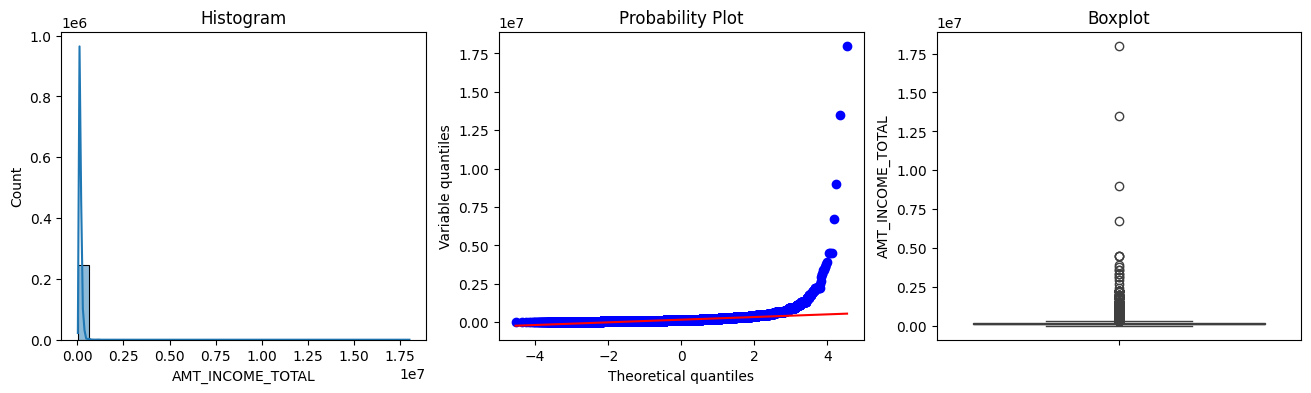

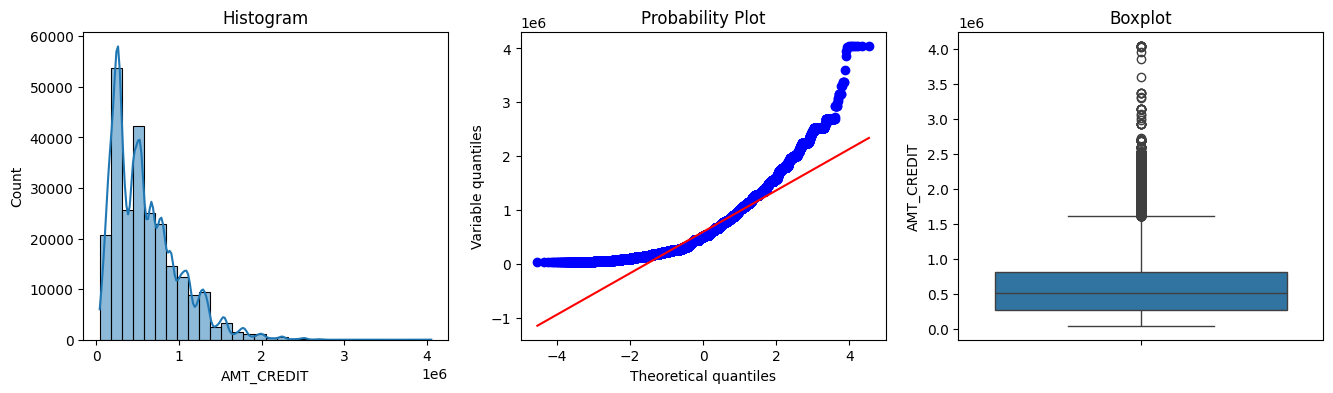

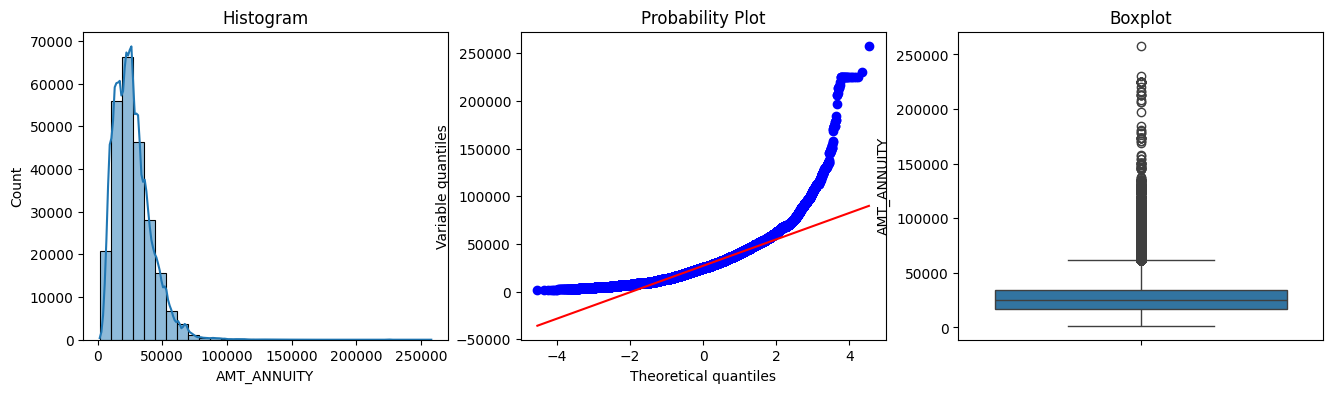

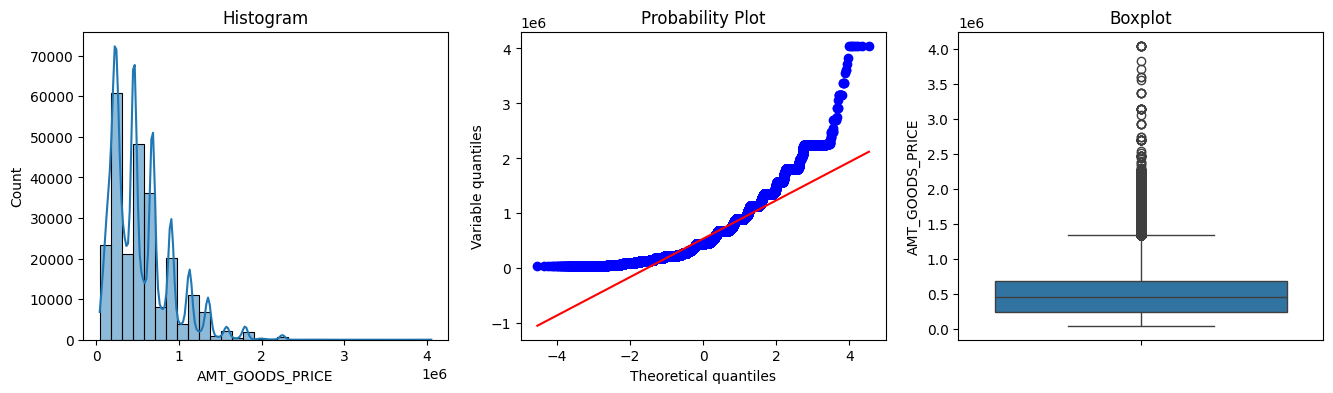

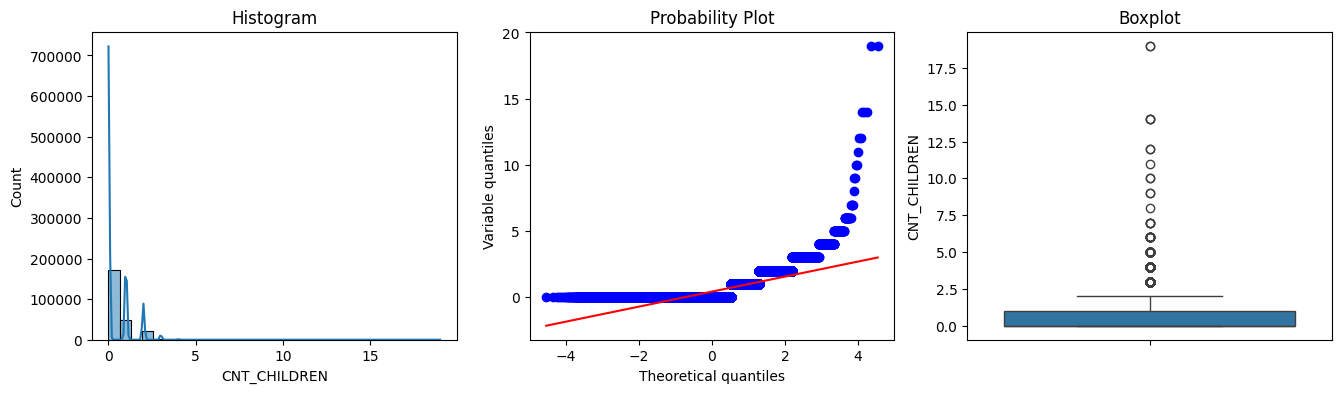

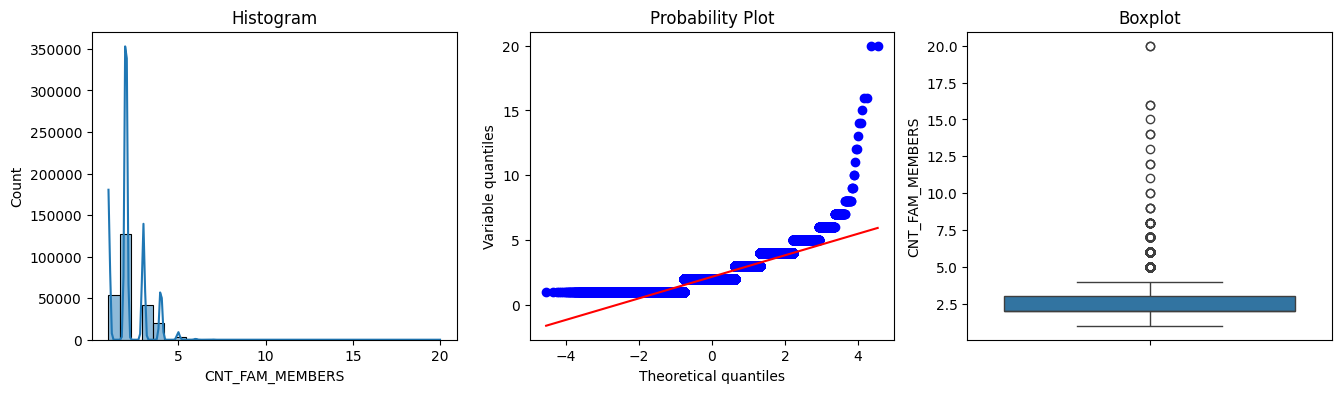

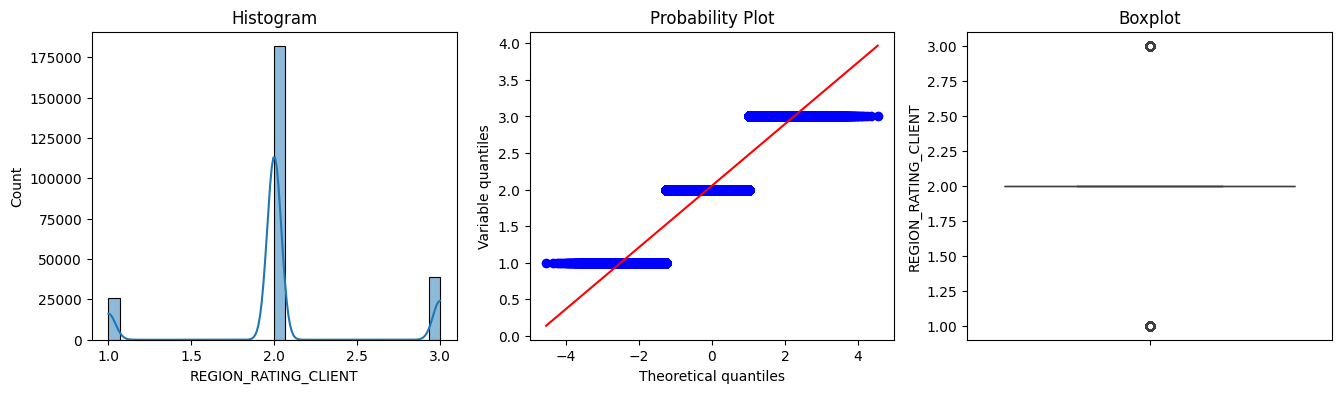

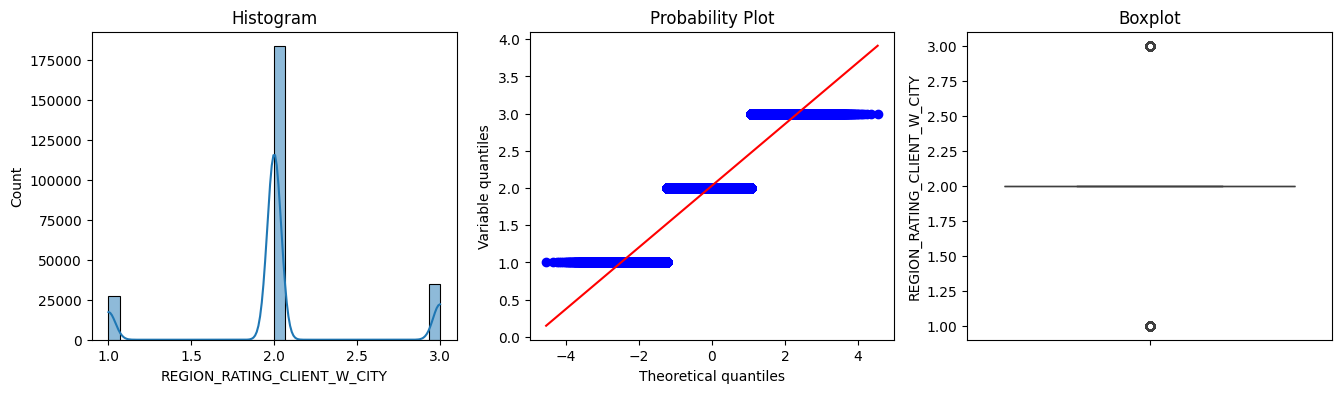

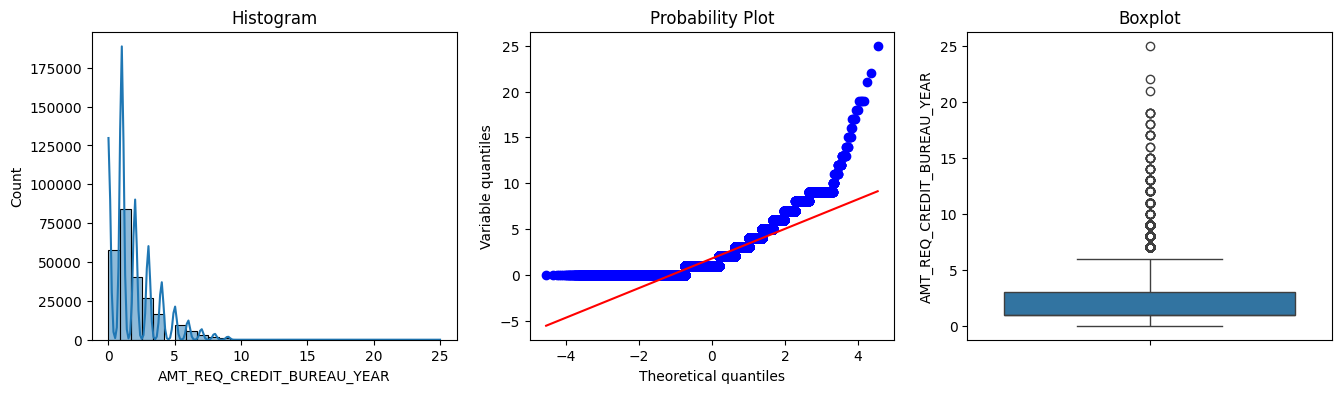

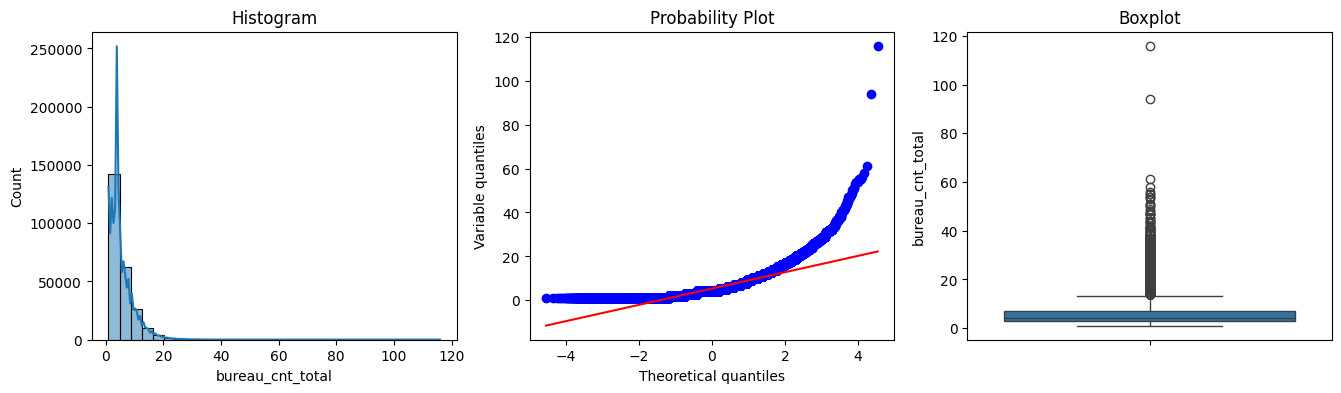

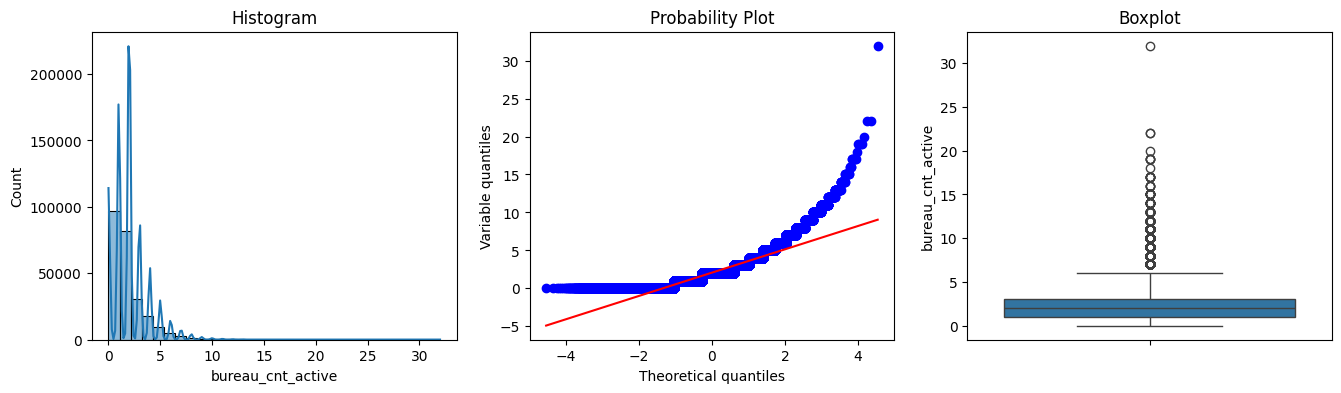

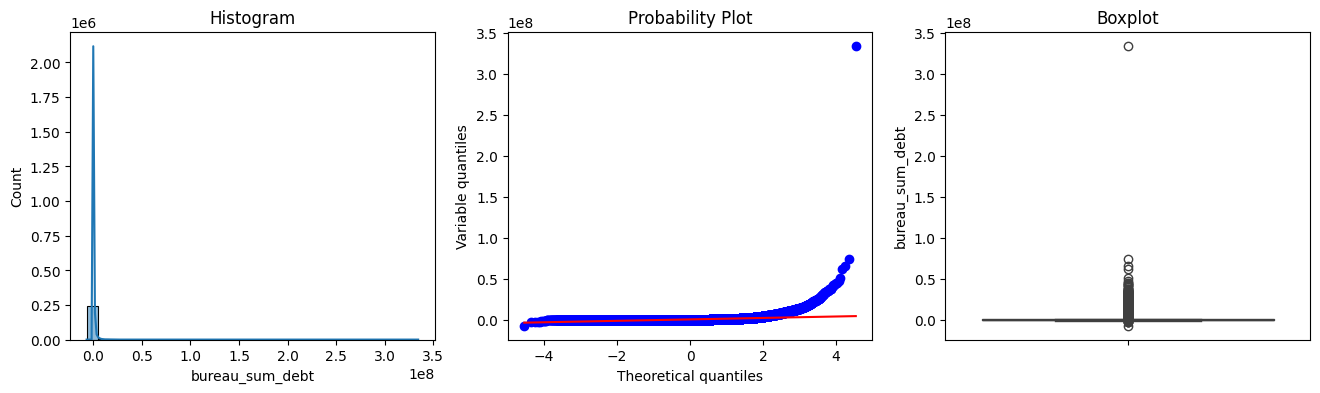

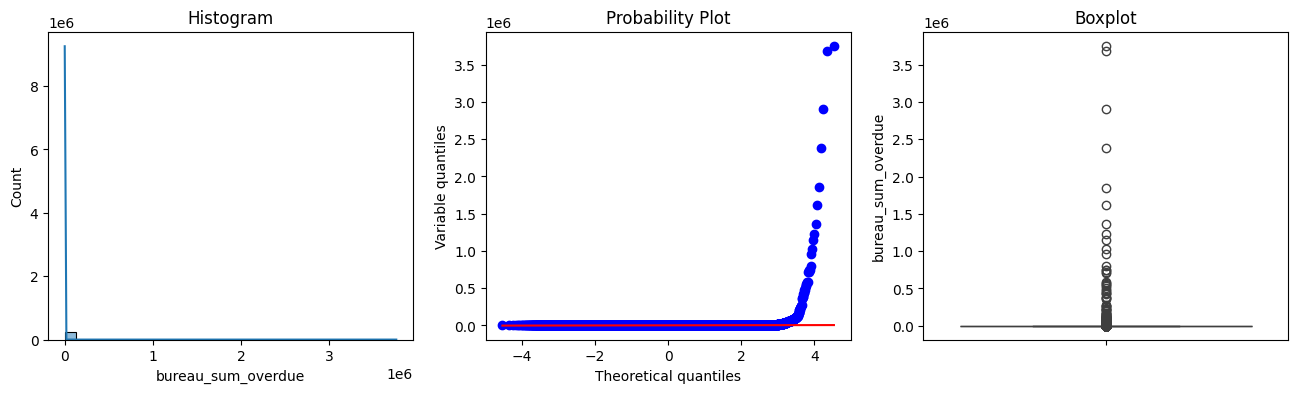

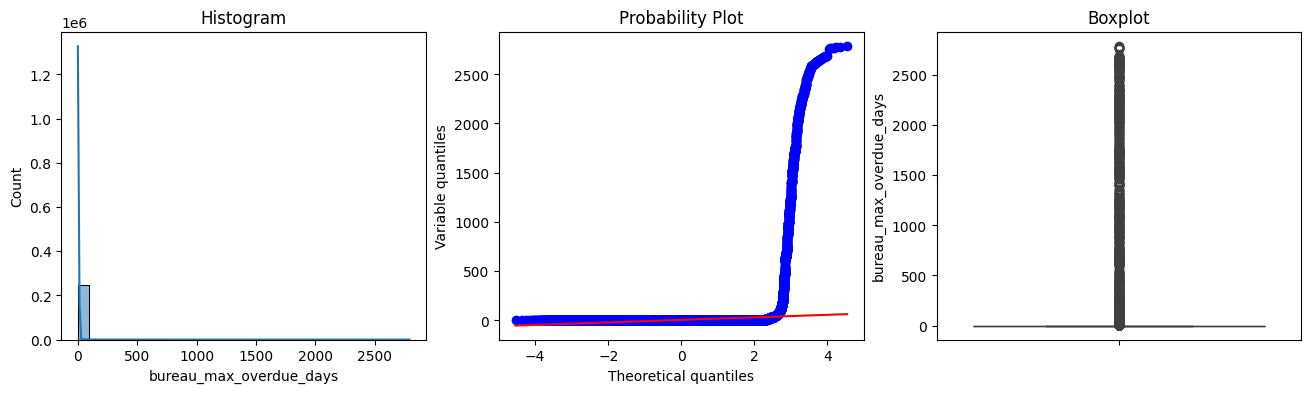

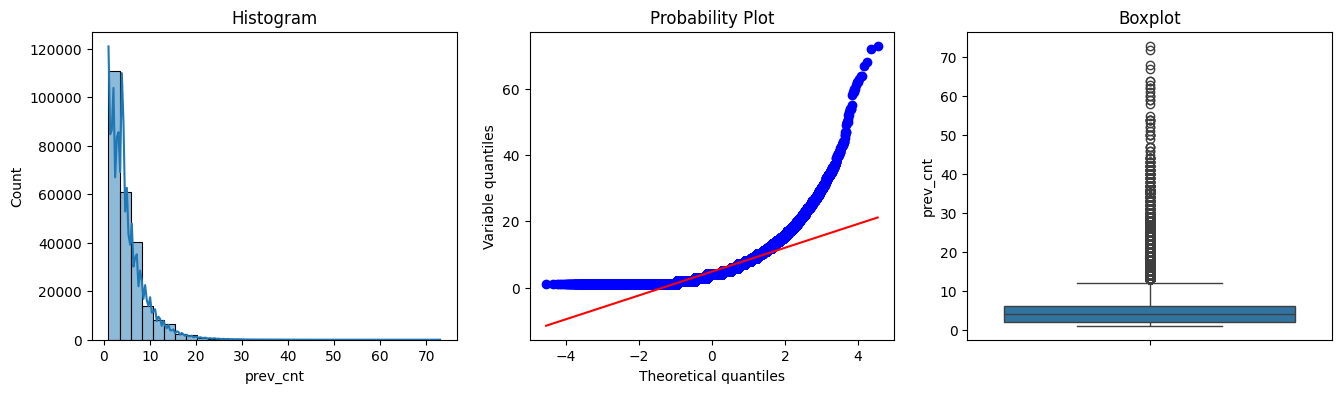

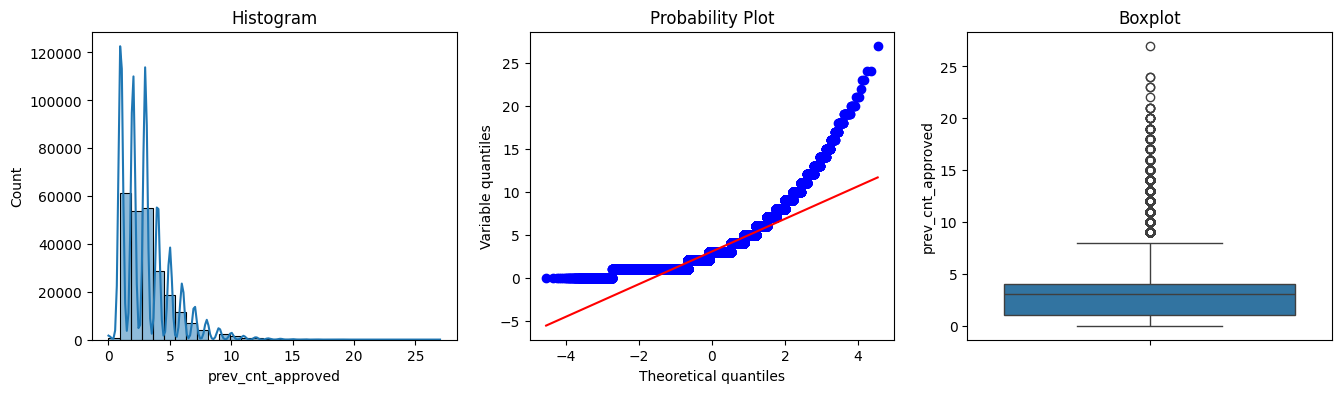

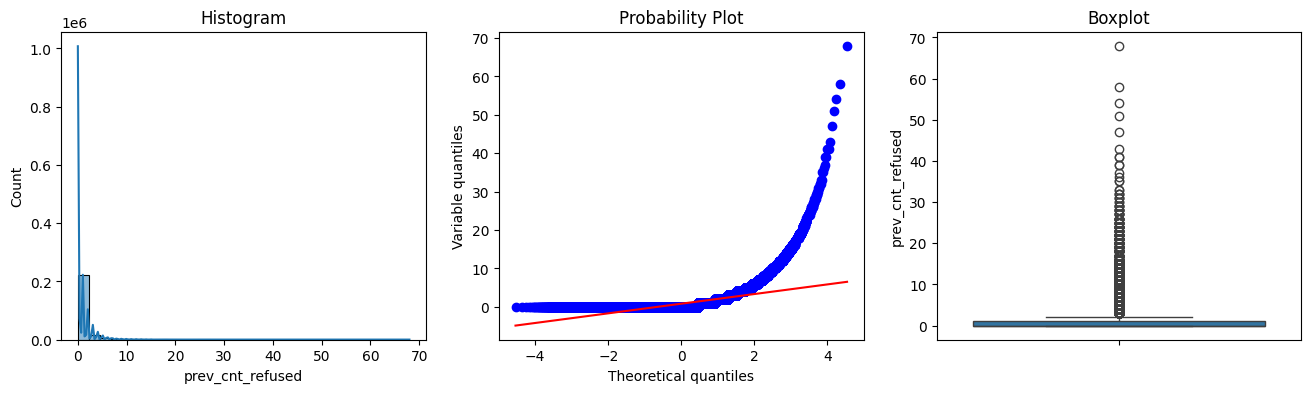

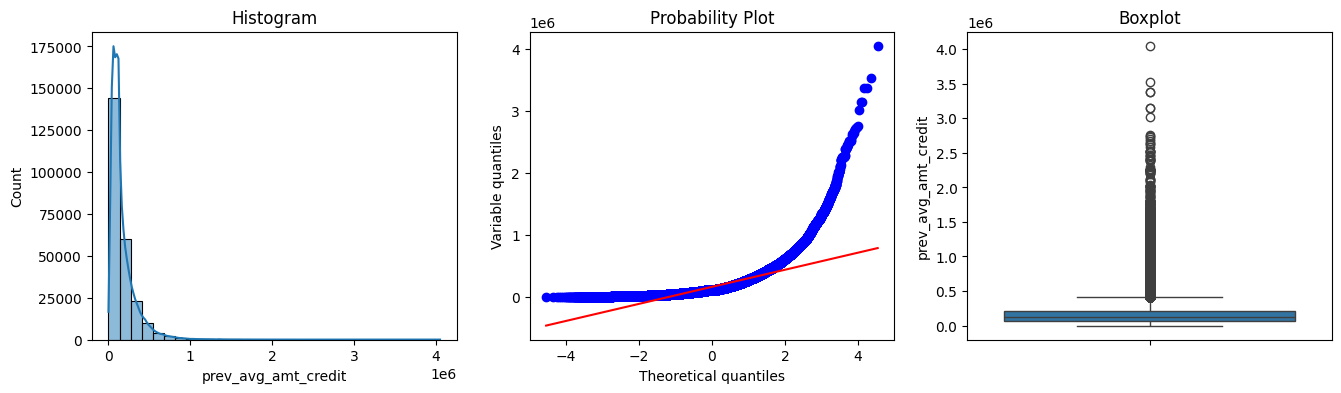

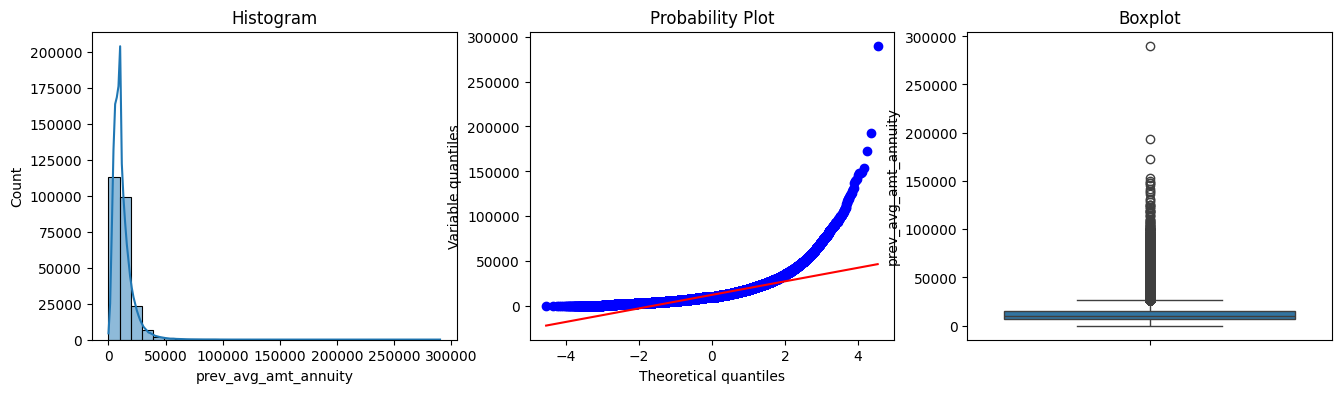

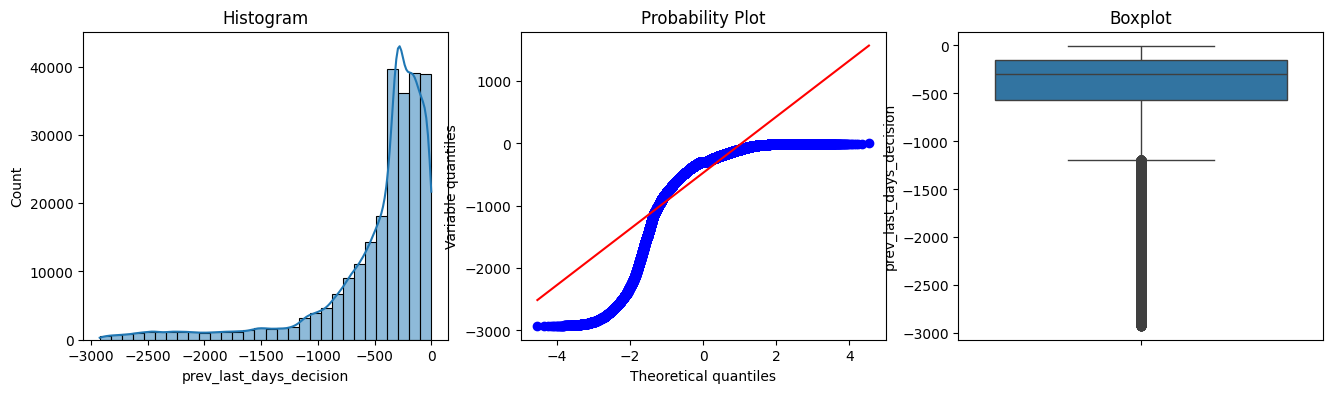

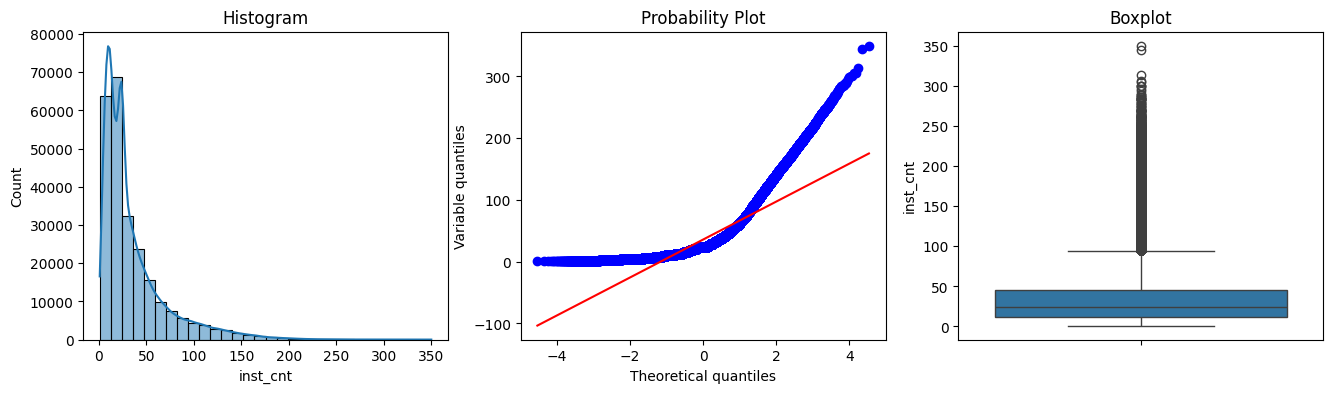

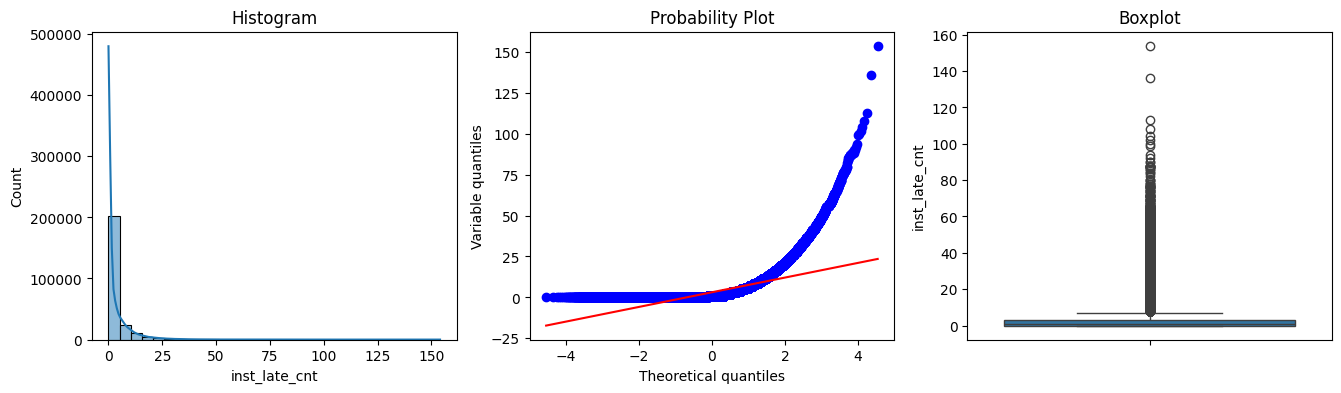

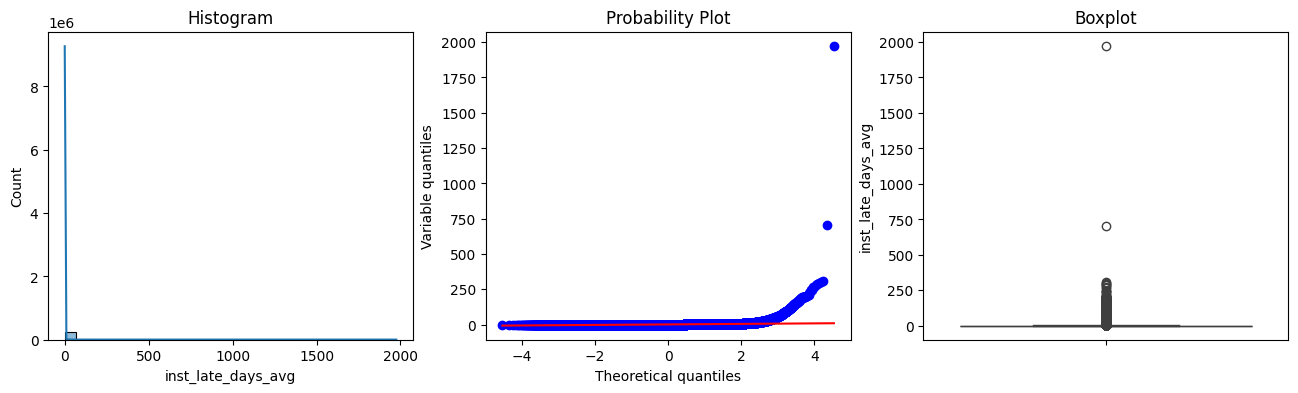

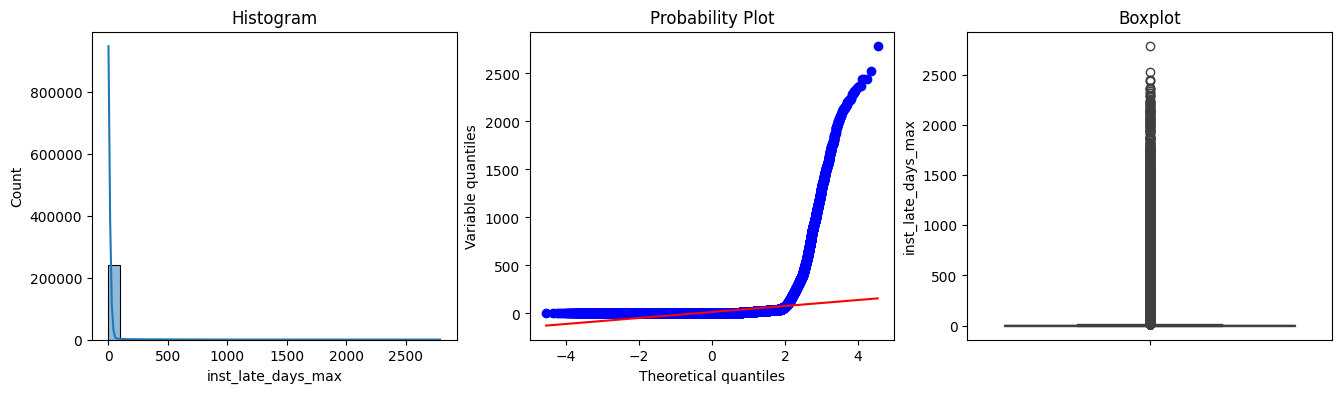

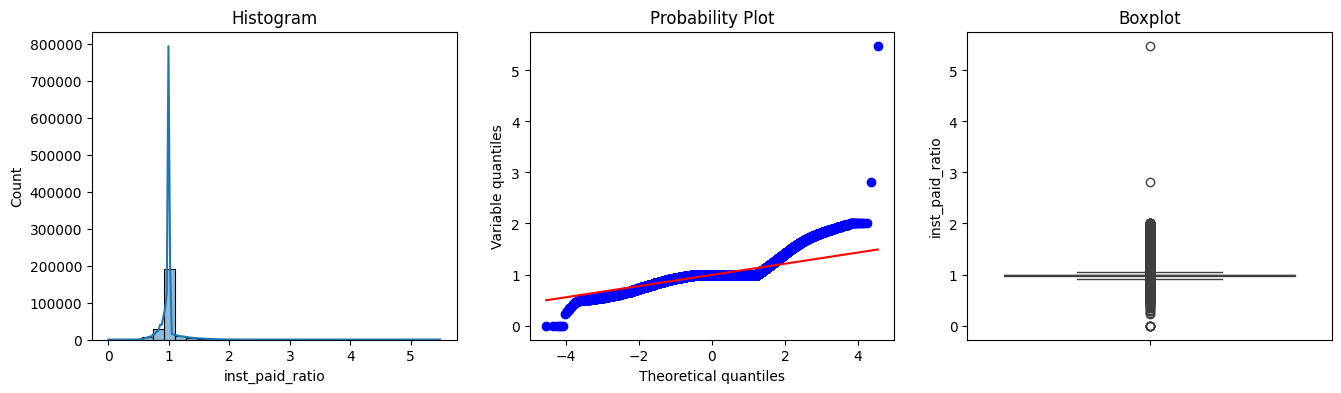

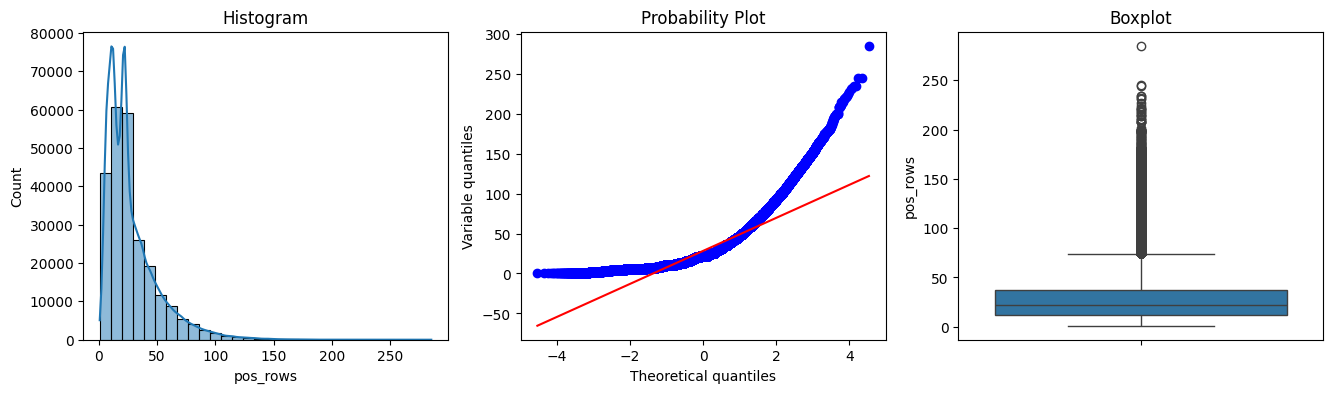

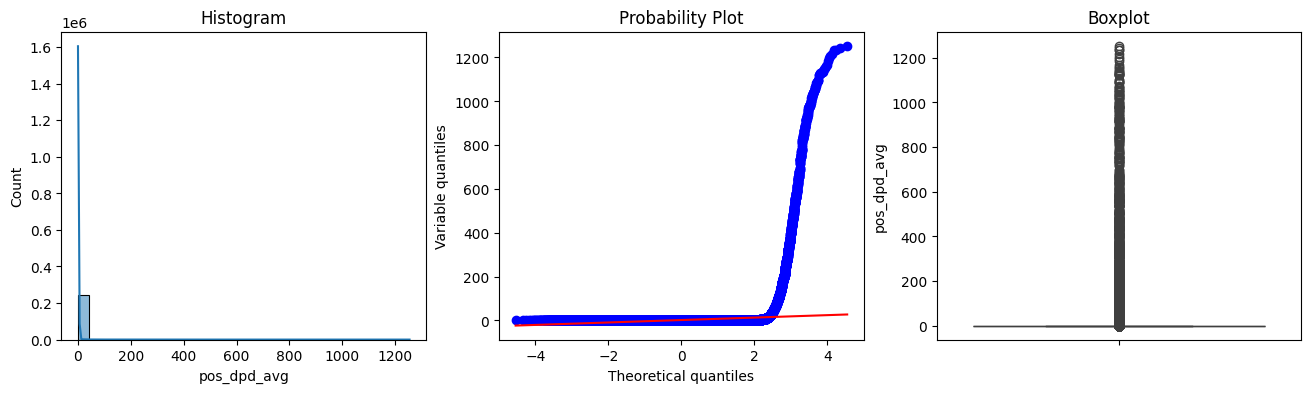

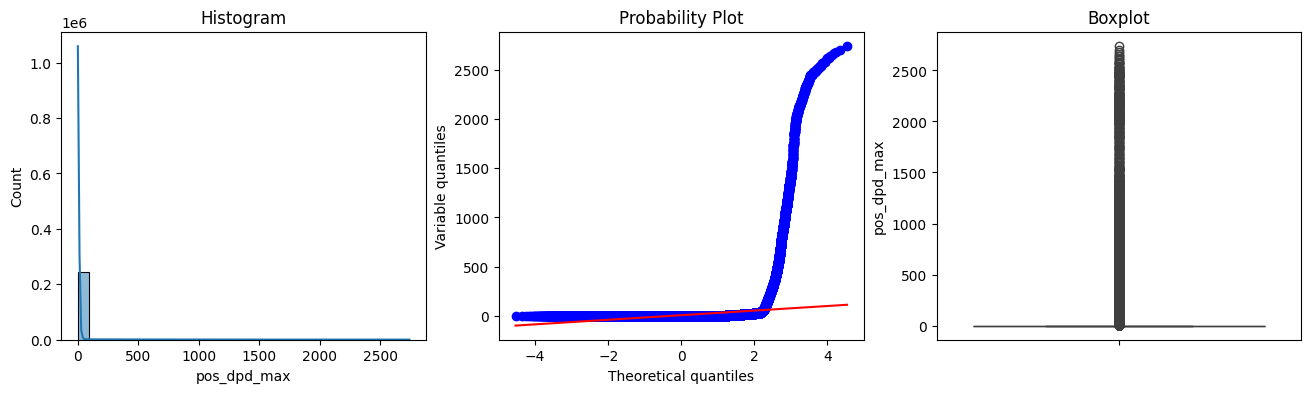

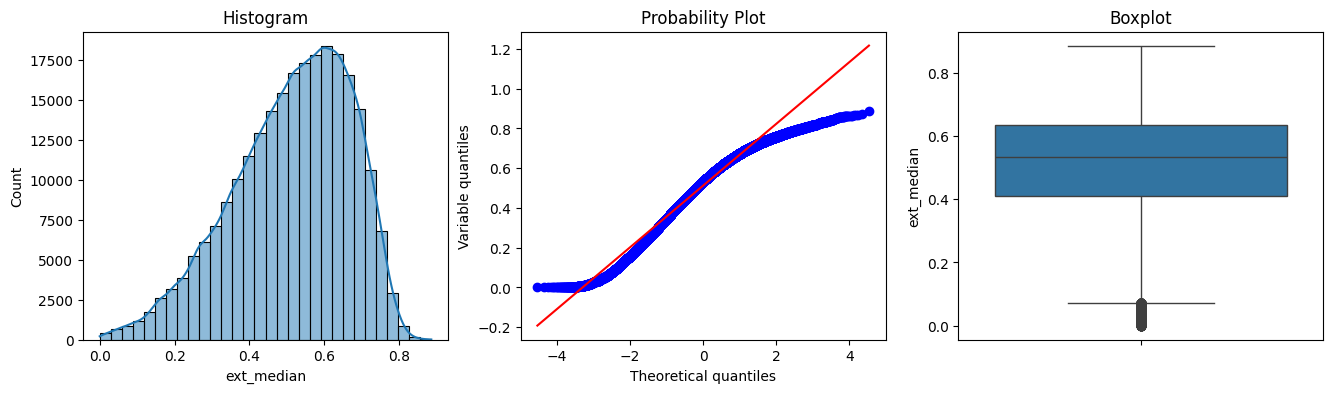

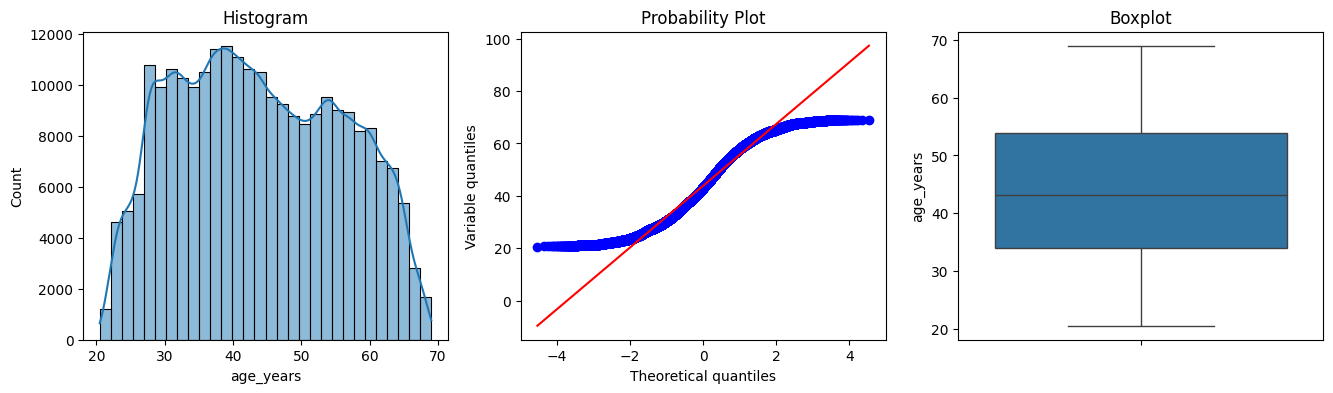

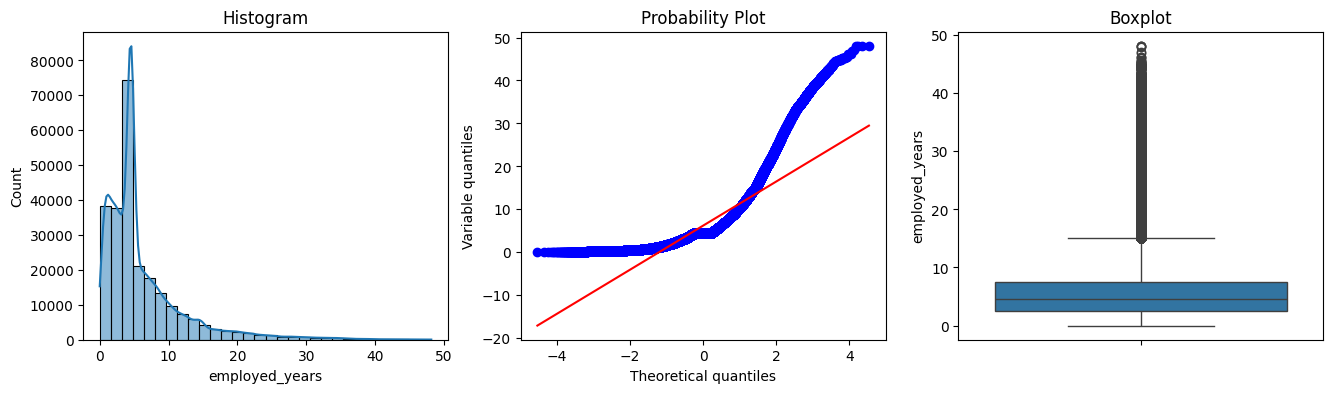

In [ ]:
import scipy.stats as stats

# visualisasikan outlier hanya pada kolom numerik
numeric_columns = df_pretrain.select_dtypes(include=['number']).columns
for col in numeric_columns:
    check_plot(df_pretrain, col)

In [ ]:
df_pretrain.select_dtypes(include=['number']).columns

Index(['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'AMT_REQ_CREDIT_BUREAU_YEAR',
       'bureau_cnt_total', 'bureau_cnt_active', 'bureau_sum_debt',
       'bureau_sum_overdue', 'bureau_max_overdue_days', 'prev_cnt',
       'prev_cnt_approved', 'prev_cnt_refused', 'prev_avg_amt_credit',
       'prev_avg_amt_annuity', 'prev_last_days_decision', 'inst_cnt',
       'inst_late_cnt', 'inst_late_days_avg', 'inst_late_days_max',
       'inst_paid_ratio', 'pos_rows', 'pos_dpd_avg', 'pos_dpd_max',
       'ext_median', 'age_years', 'employed_years'],
      dtype='object')

In [ ]:
#handling outlier dengan np.log

outlier_columns = ['AMT_INCOME_TOTAL', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'bureau_cnt_total', 'bureau_cnt_active',
       'prev_cnt',
       'prev_cnt_approved', 'prev_cnt_refused', 'prev_avg_amt_credit',
       'prev_avg_amt_annuity', 'inst_cnt',
       'inst_late_cnt', 'inst_late_days_avg', 'inst_late_days_max',
       'inst_paid_ratio', 'pos_rows', 'pos_dpd_avg', 'pos_dpd_max']

for col in outlier_columns:
    df_pretrain[col] = np.log1p(df_pretrain[col])
    df_test[col] = np.log1p(df_test[col])

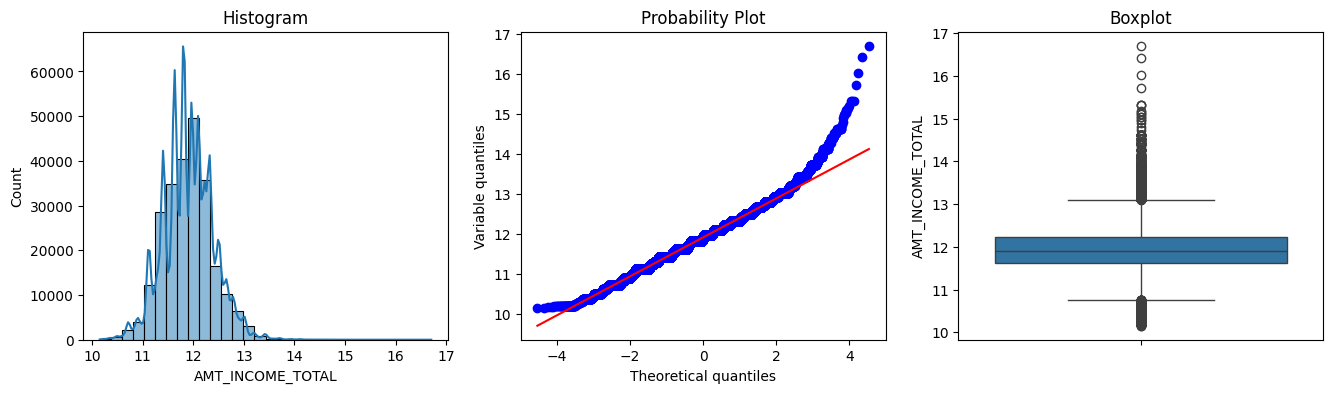

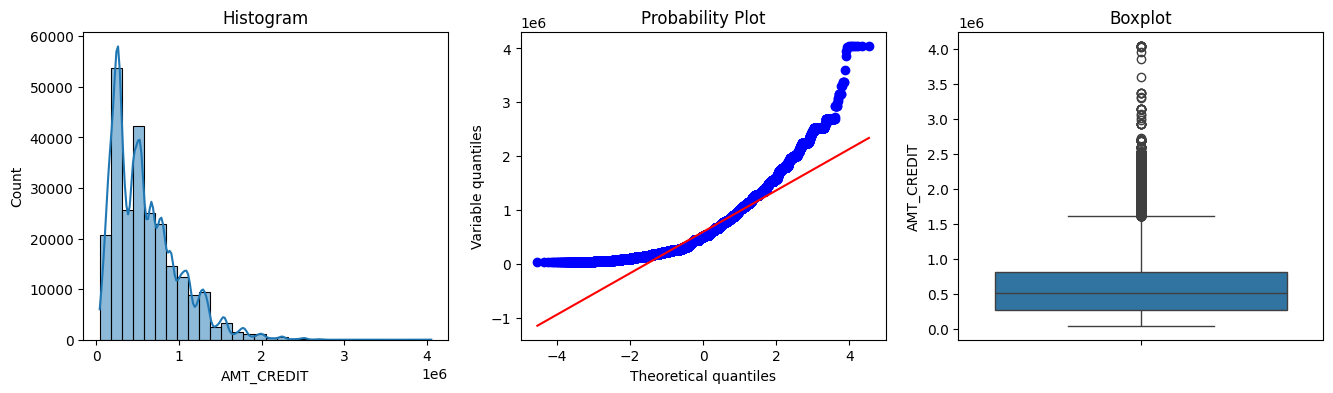

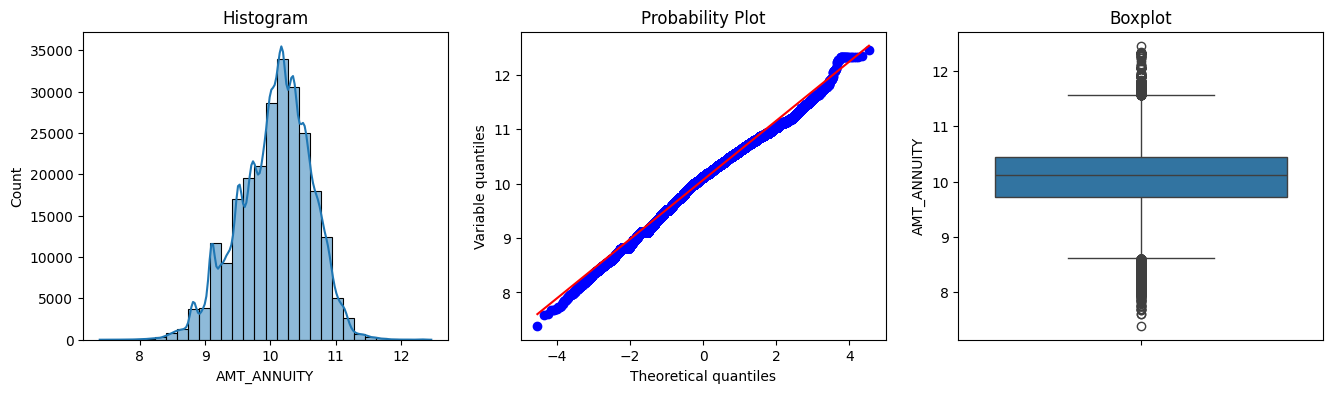

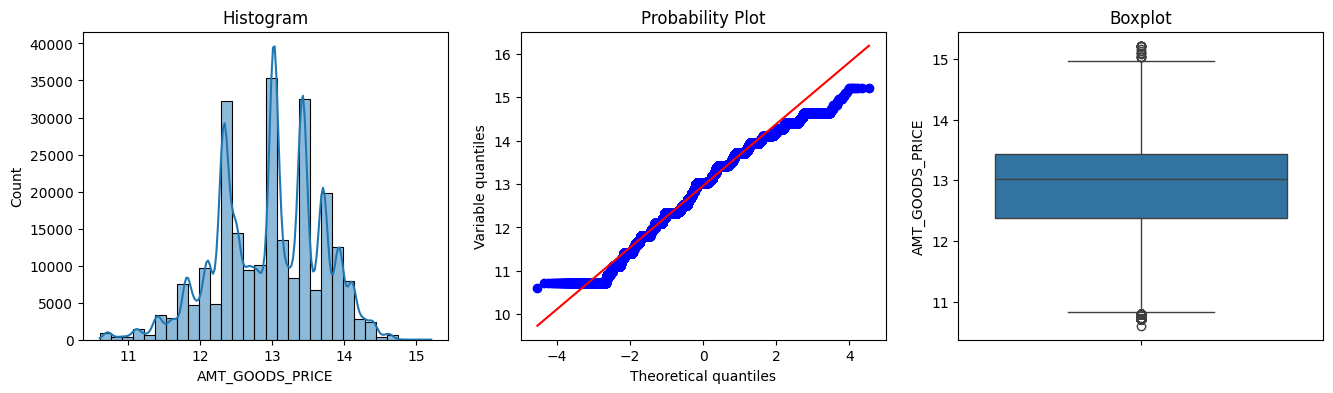

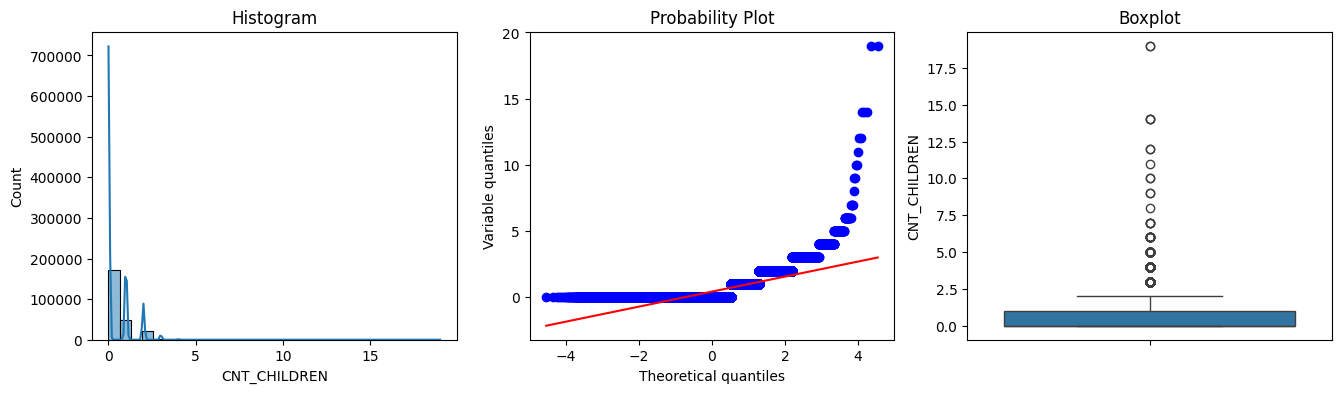

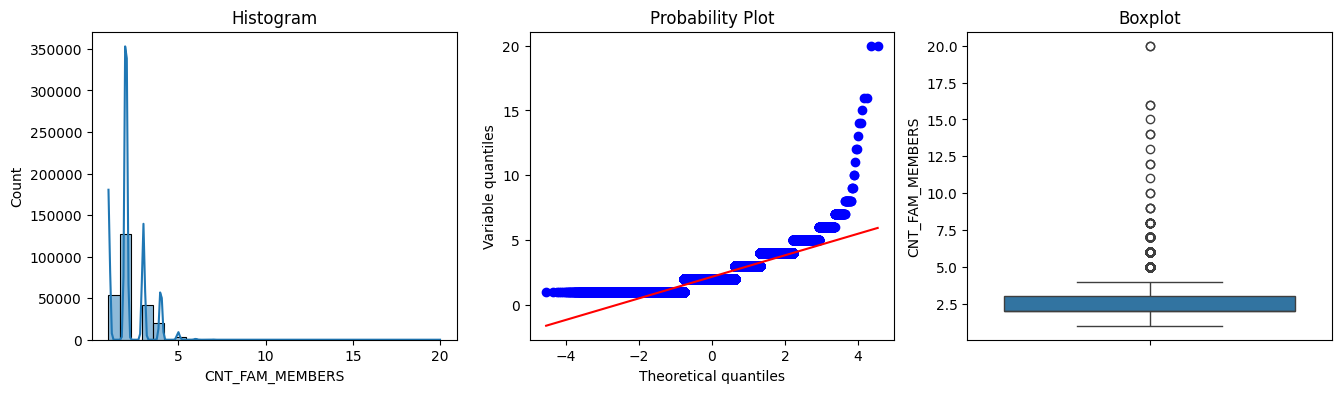

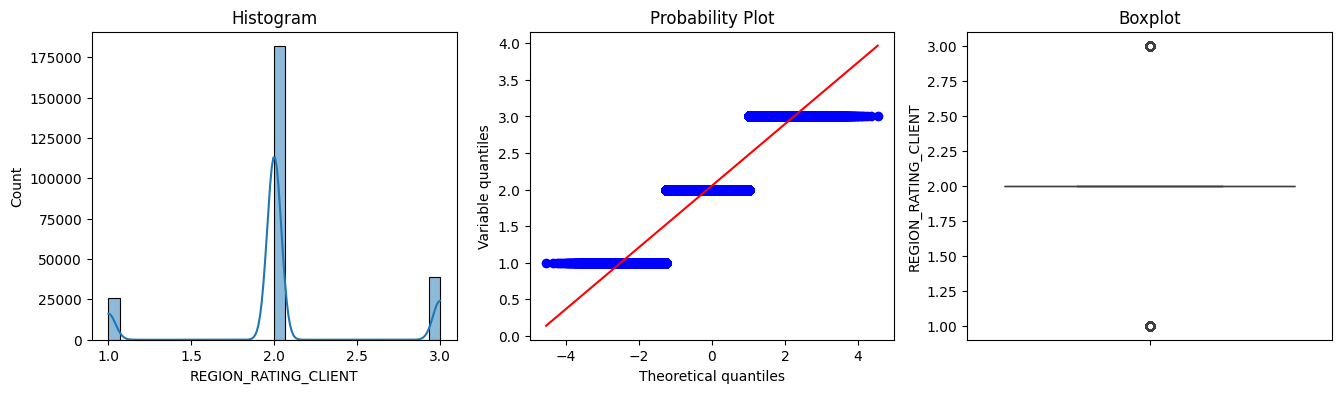

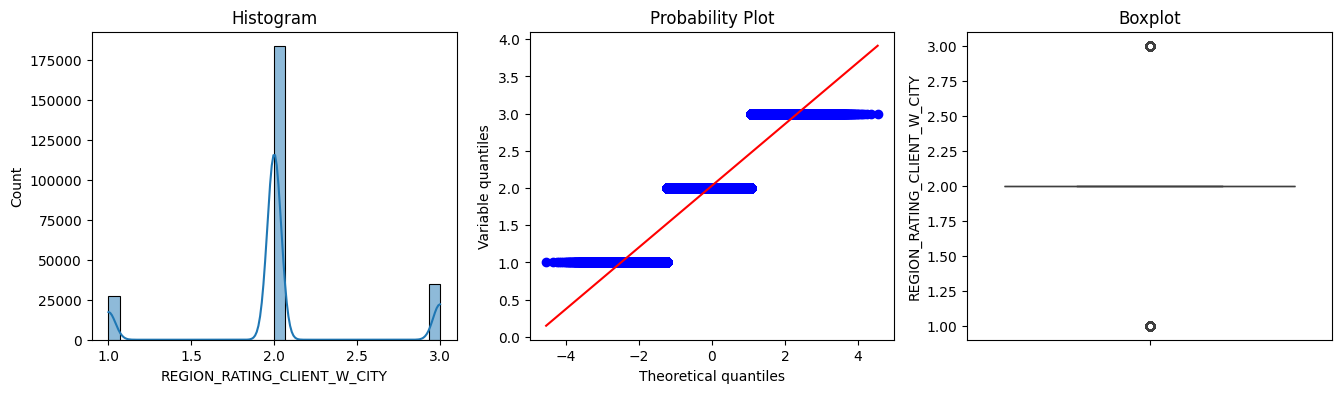

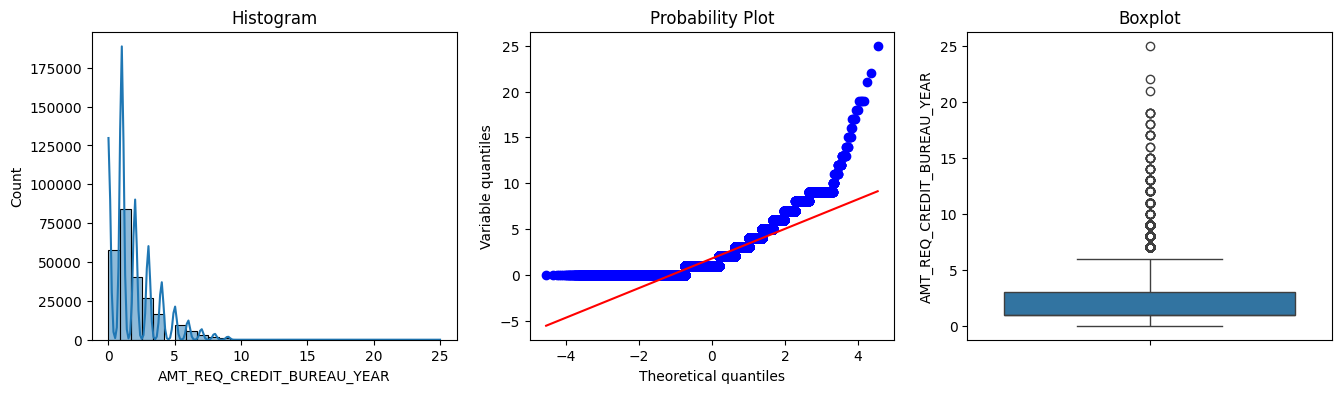

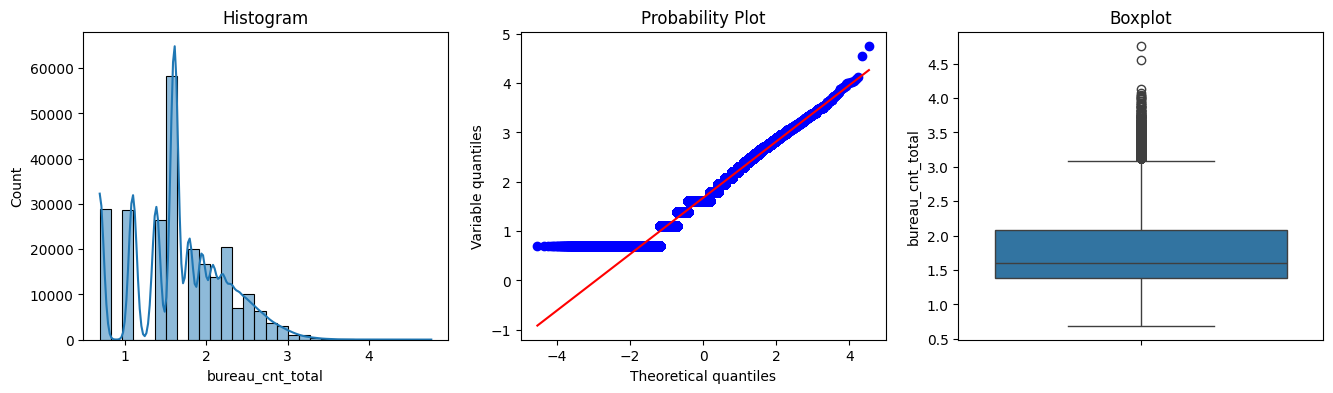

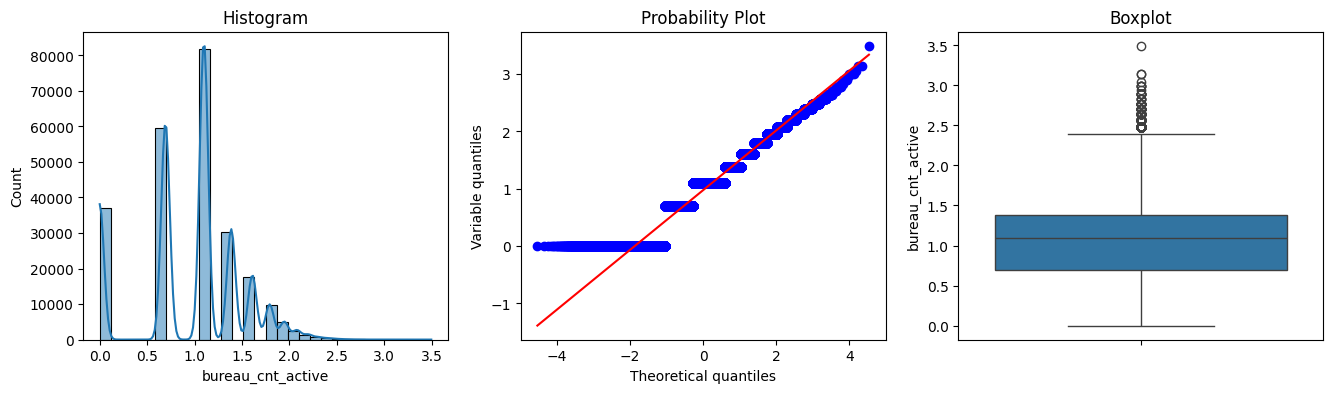

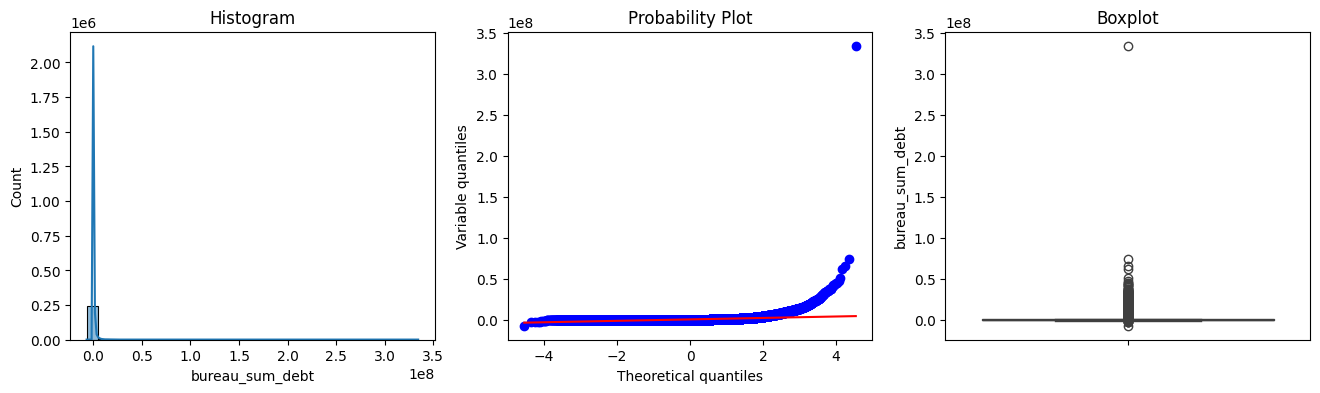

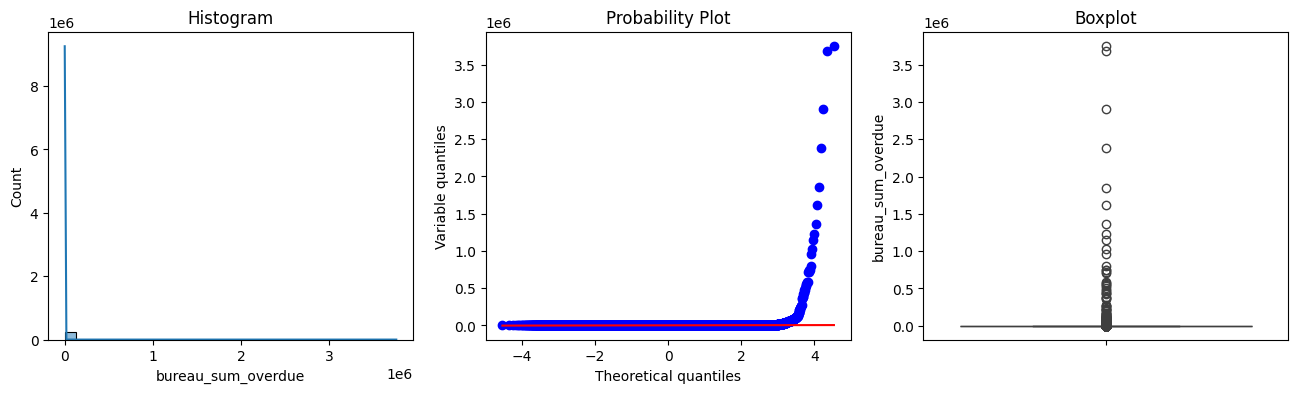

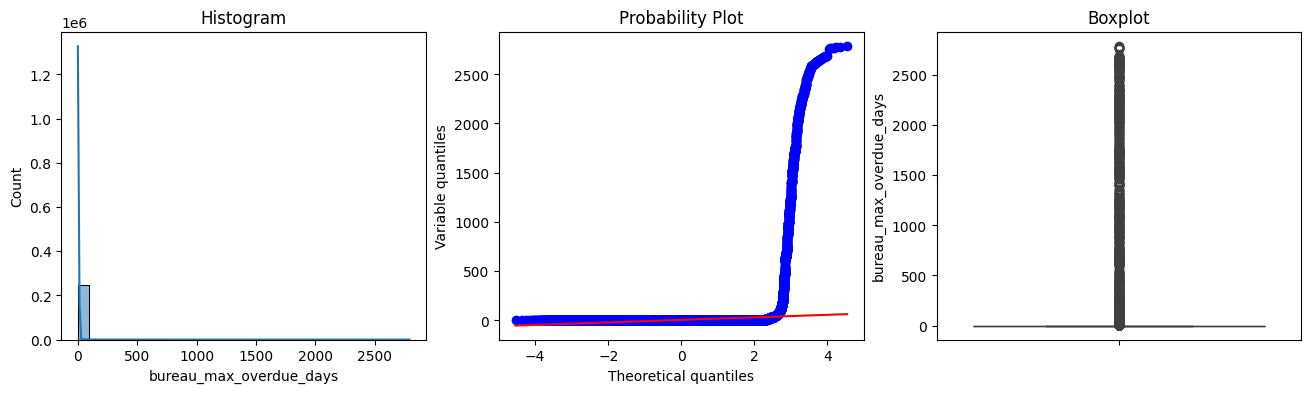

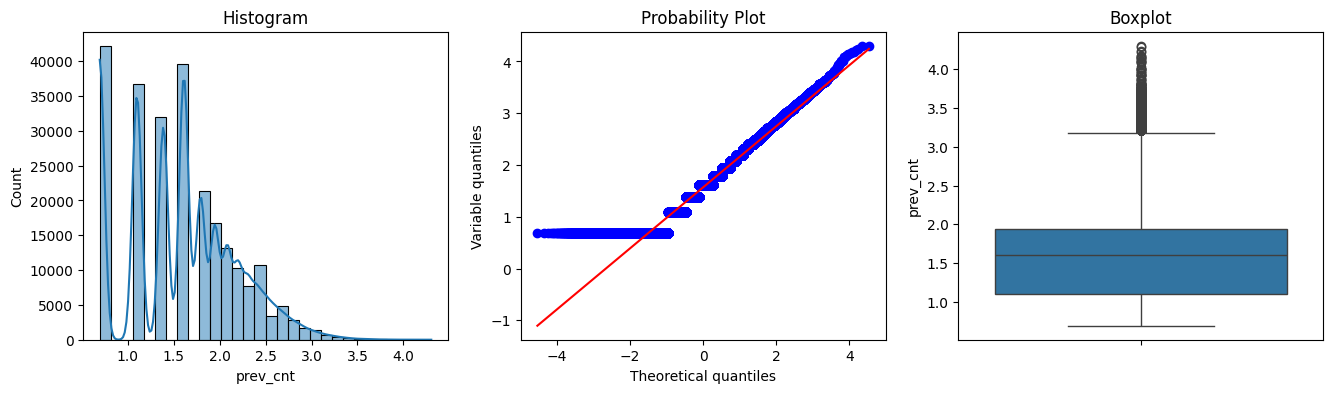

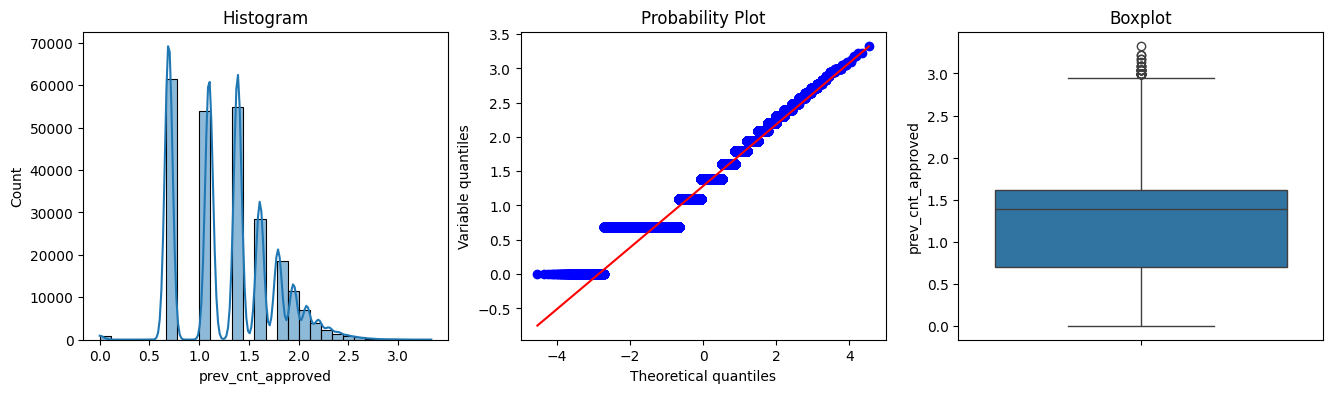

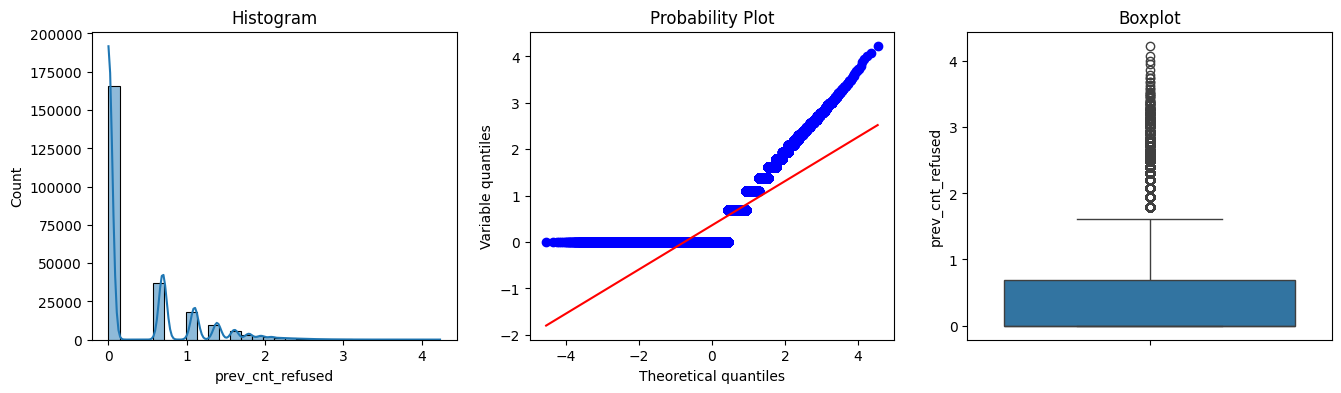

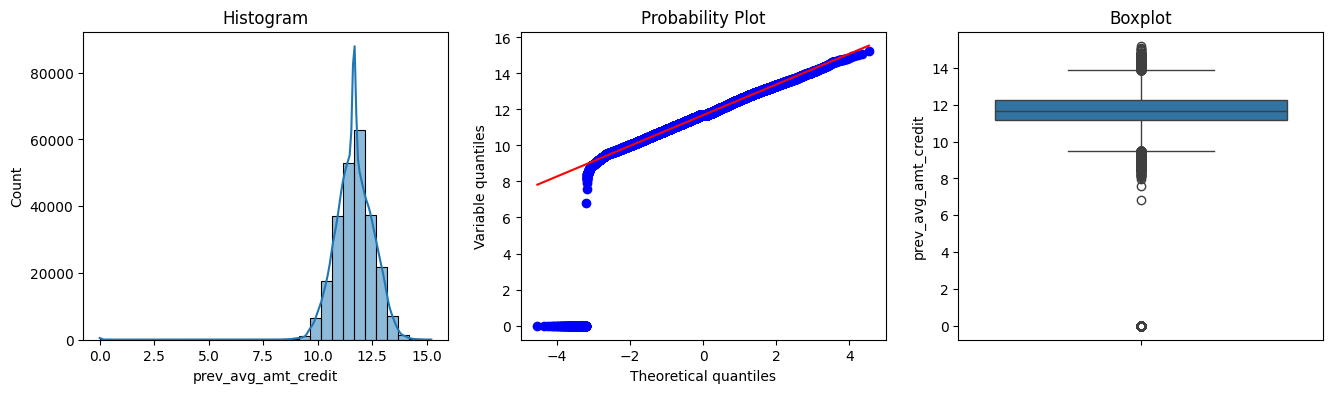

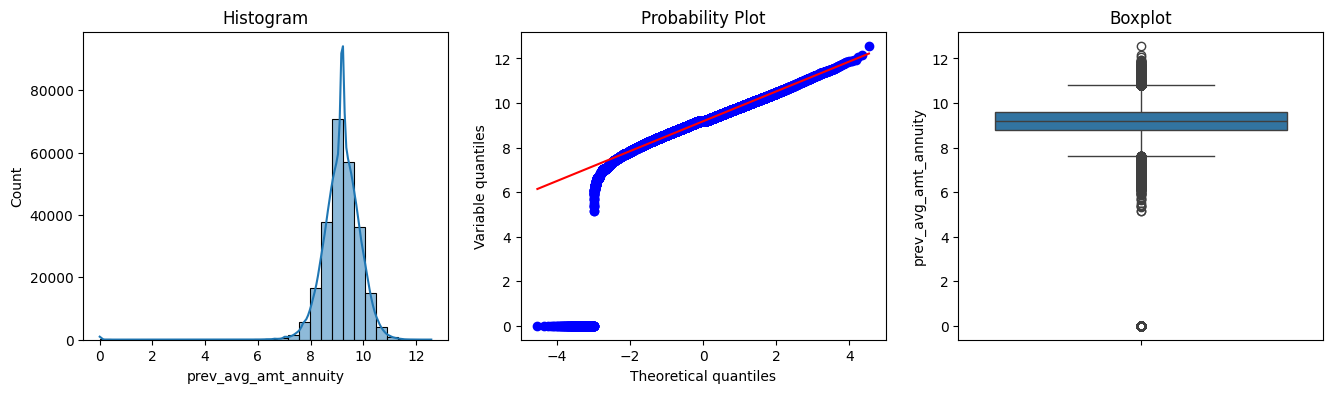

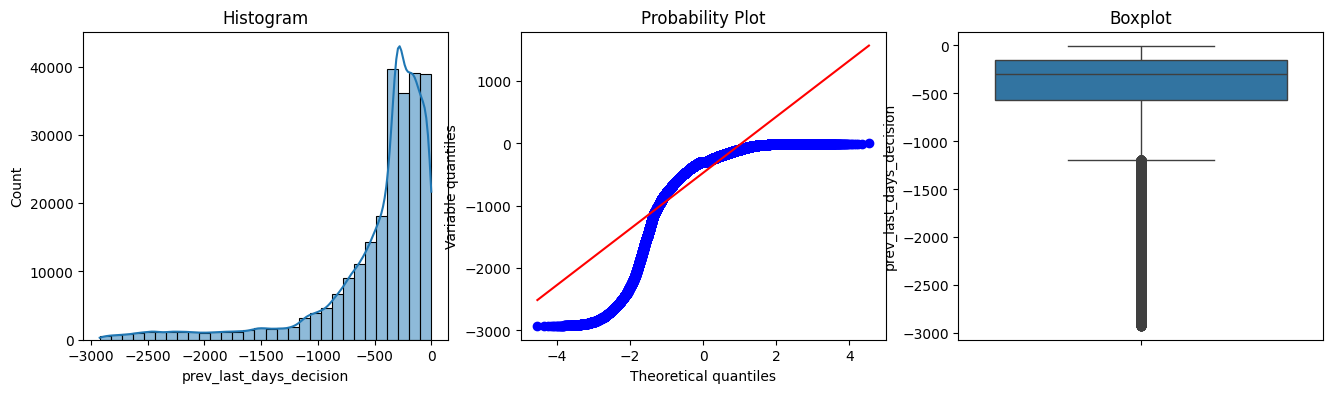

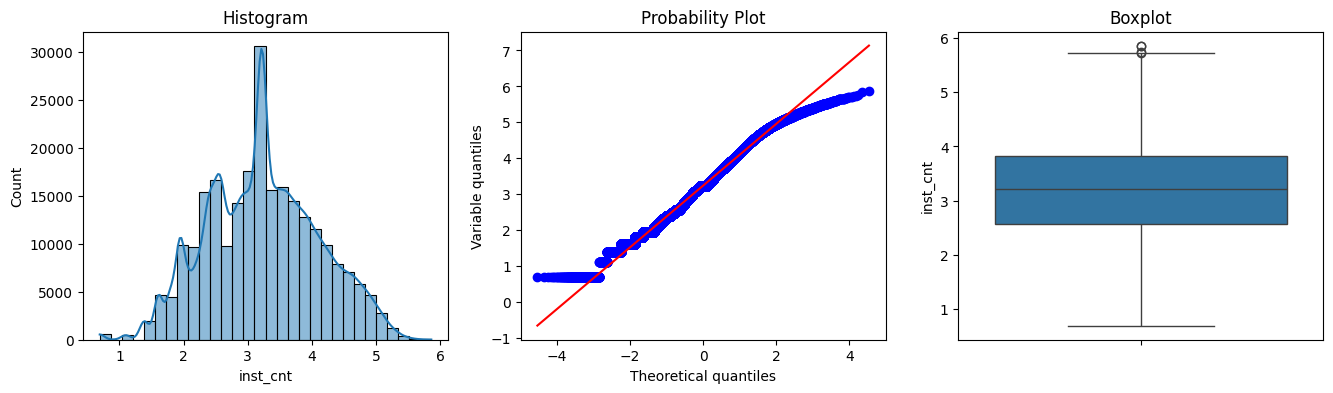

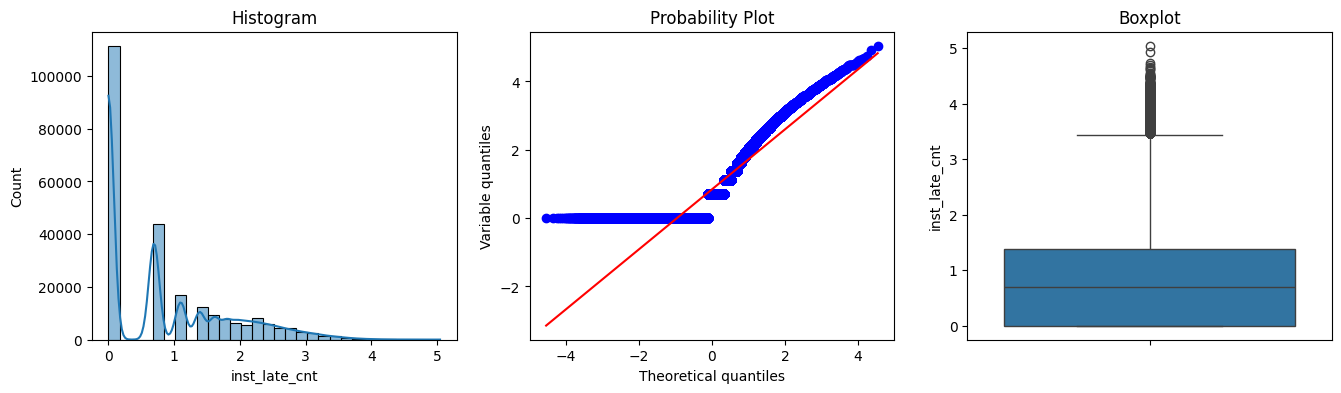

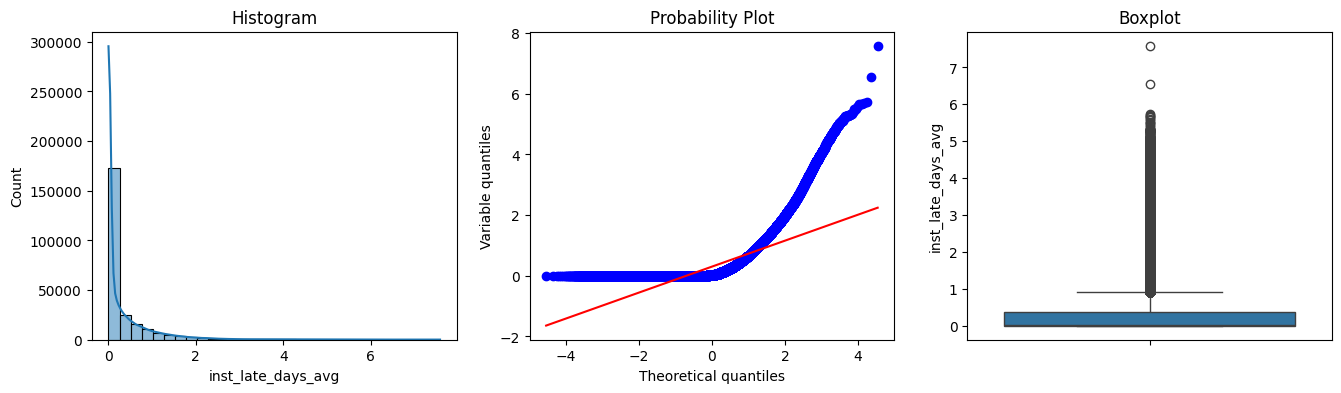

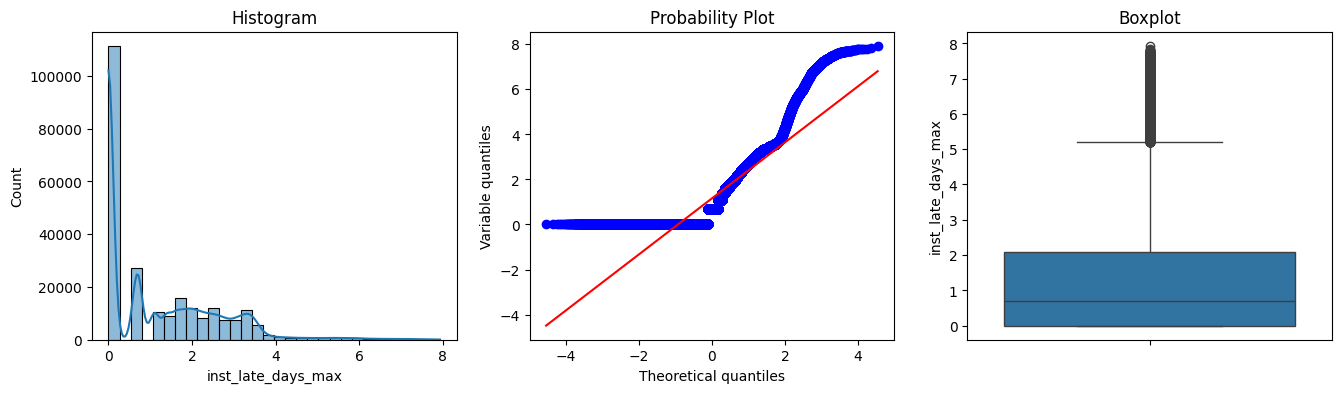

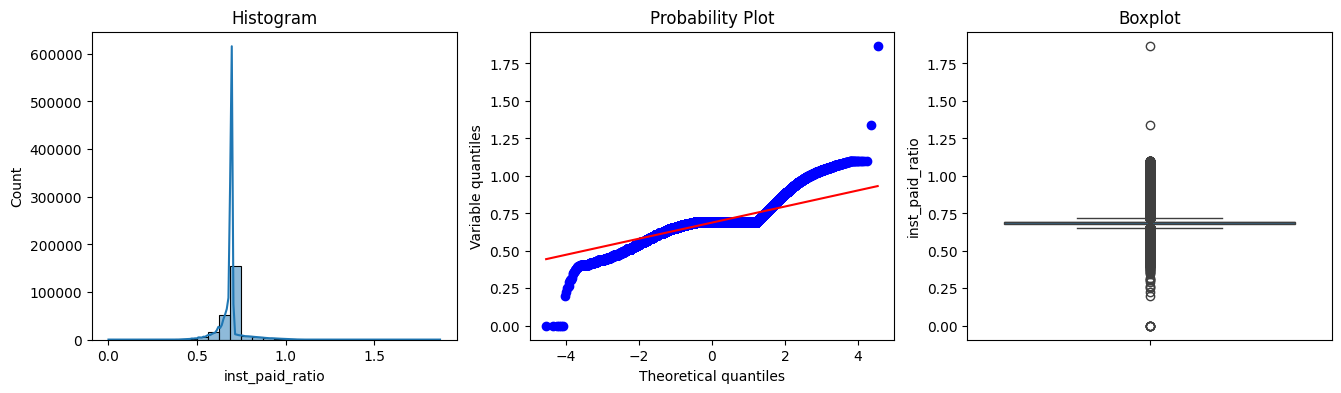

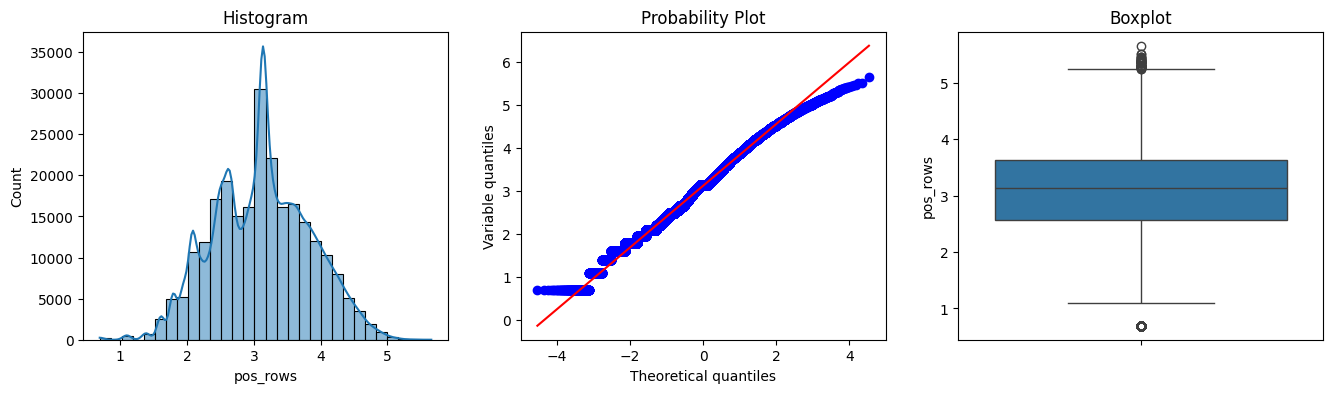

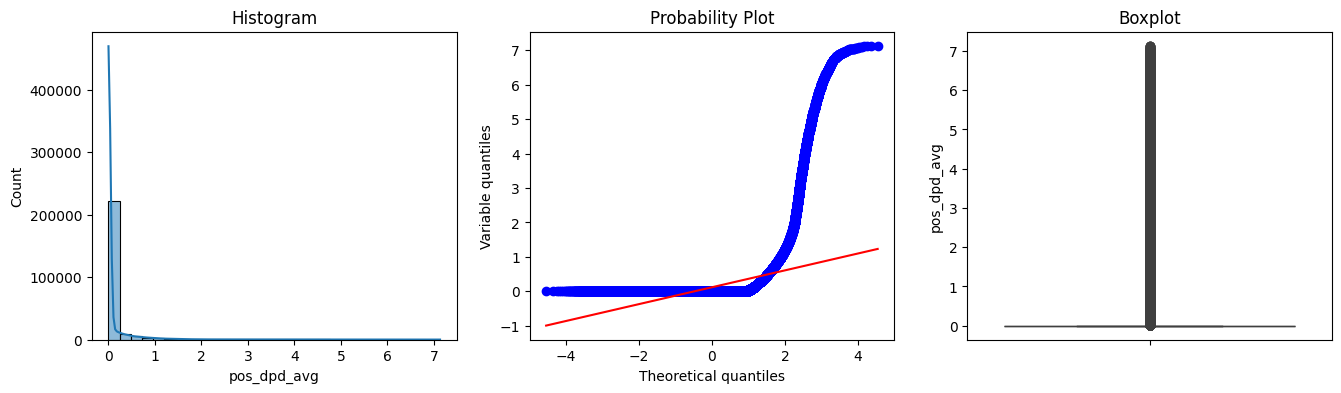

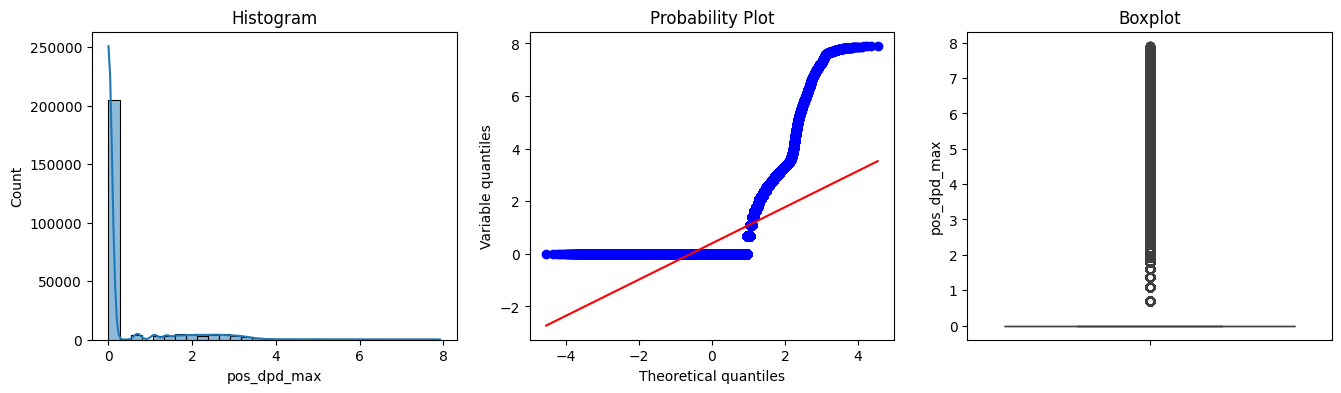

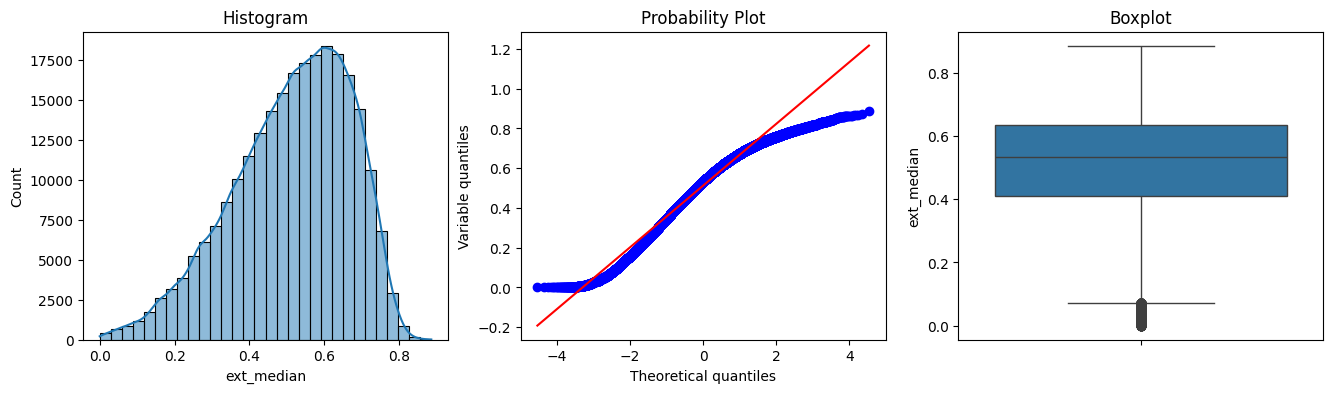

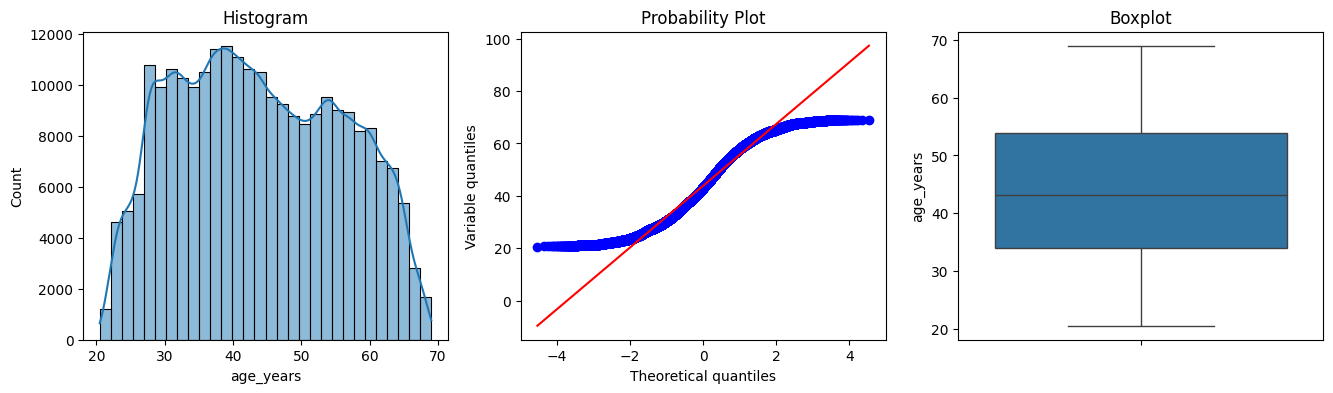

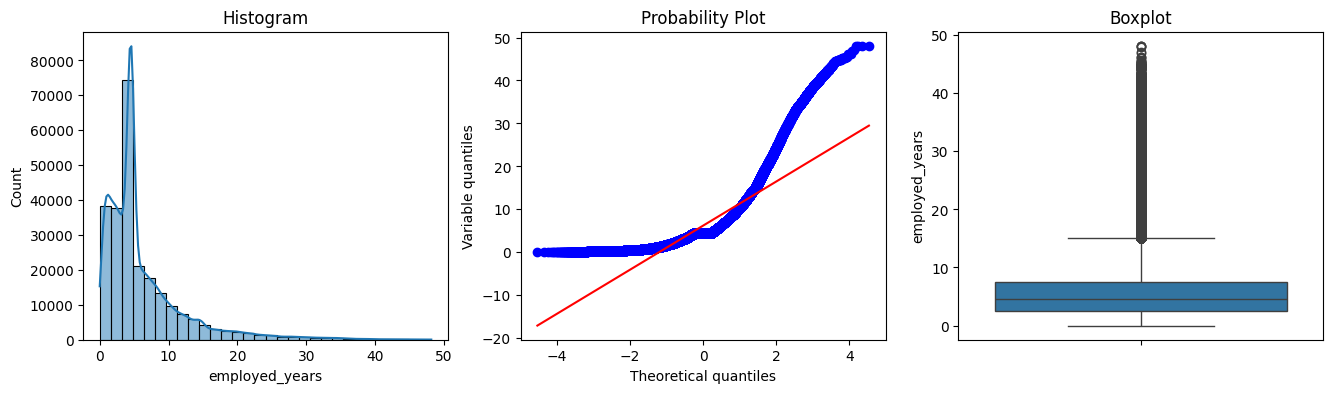

In [ ]:
import scipy.stats as stats

# visualisasikan outlier hanya pada kolom numerik
numeric_columns = df_pretrain.select_dtypes(include=['number']).columns
for col in numeric_columns:
    check_plot(df_pretrain, col)

<Axes: >

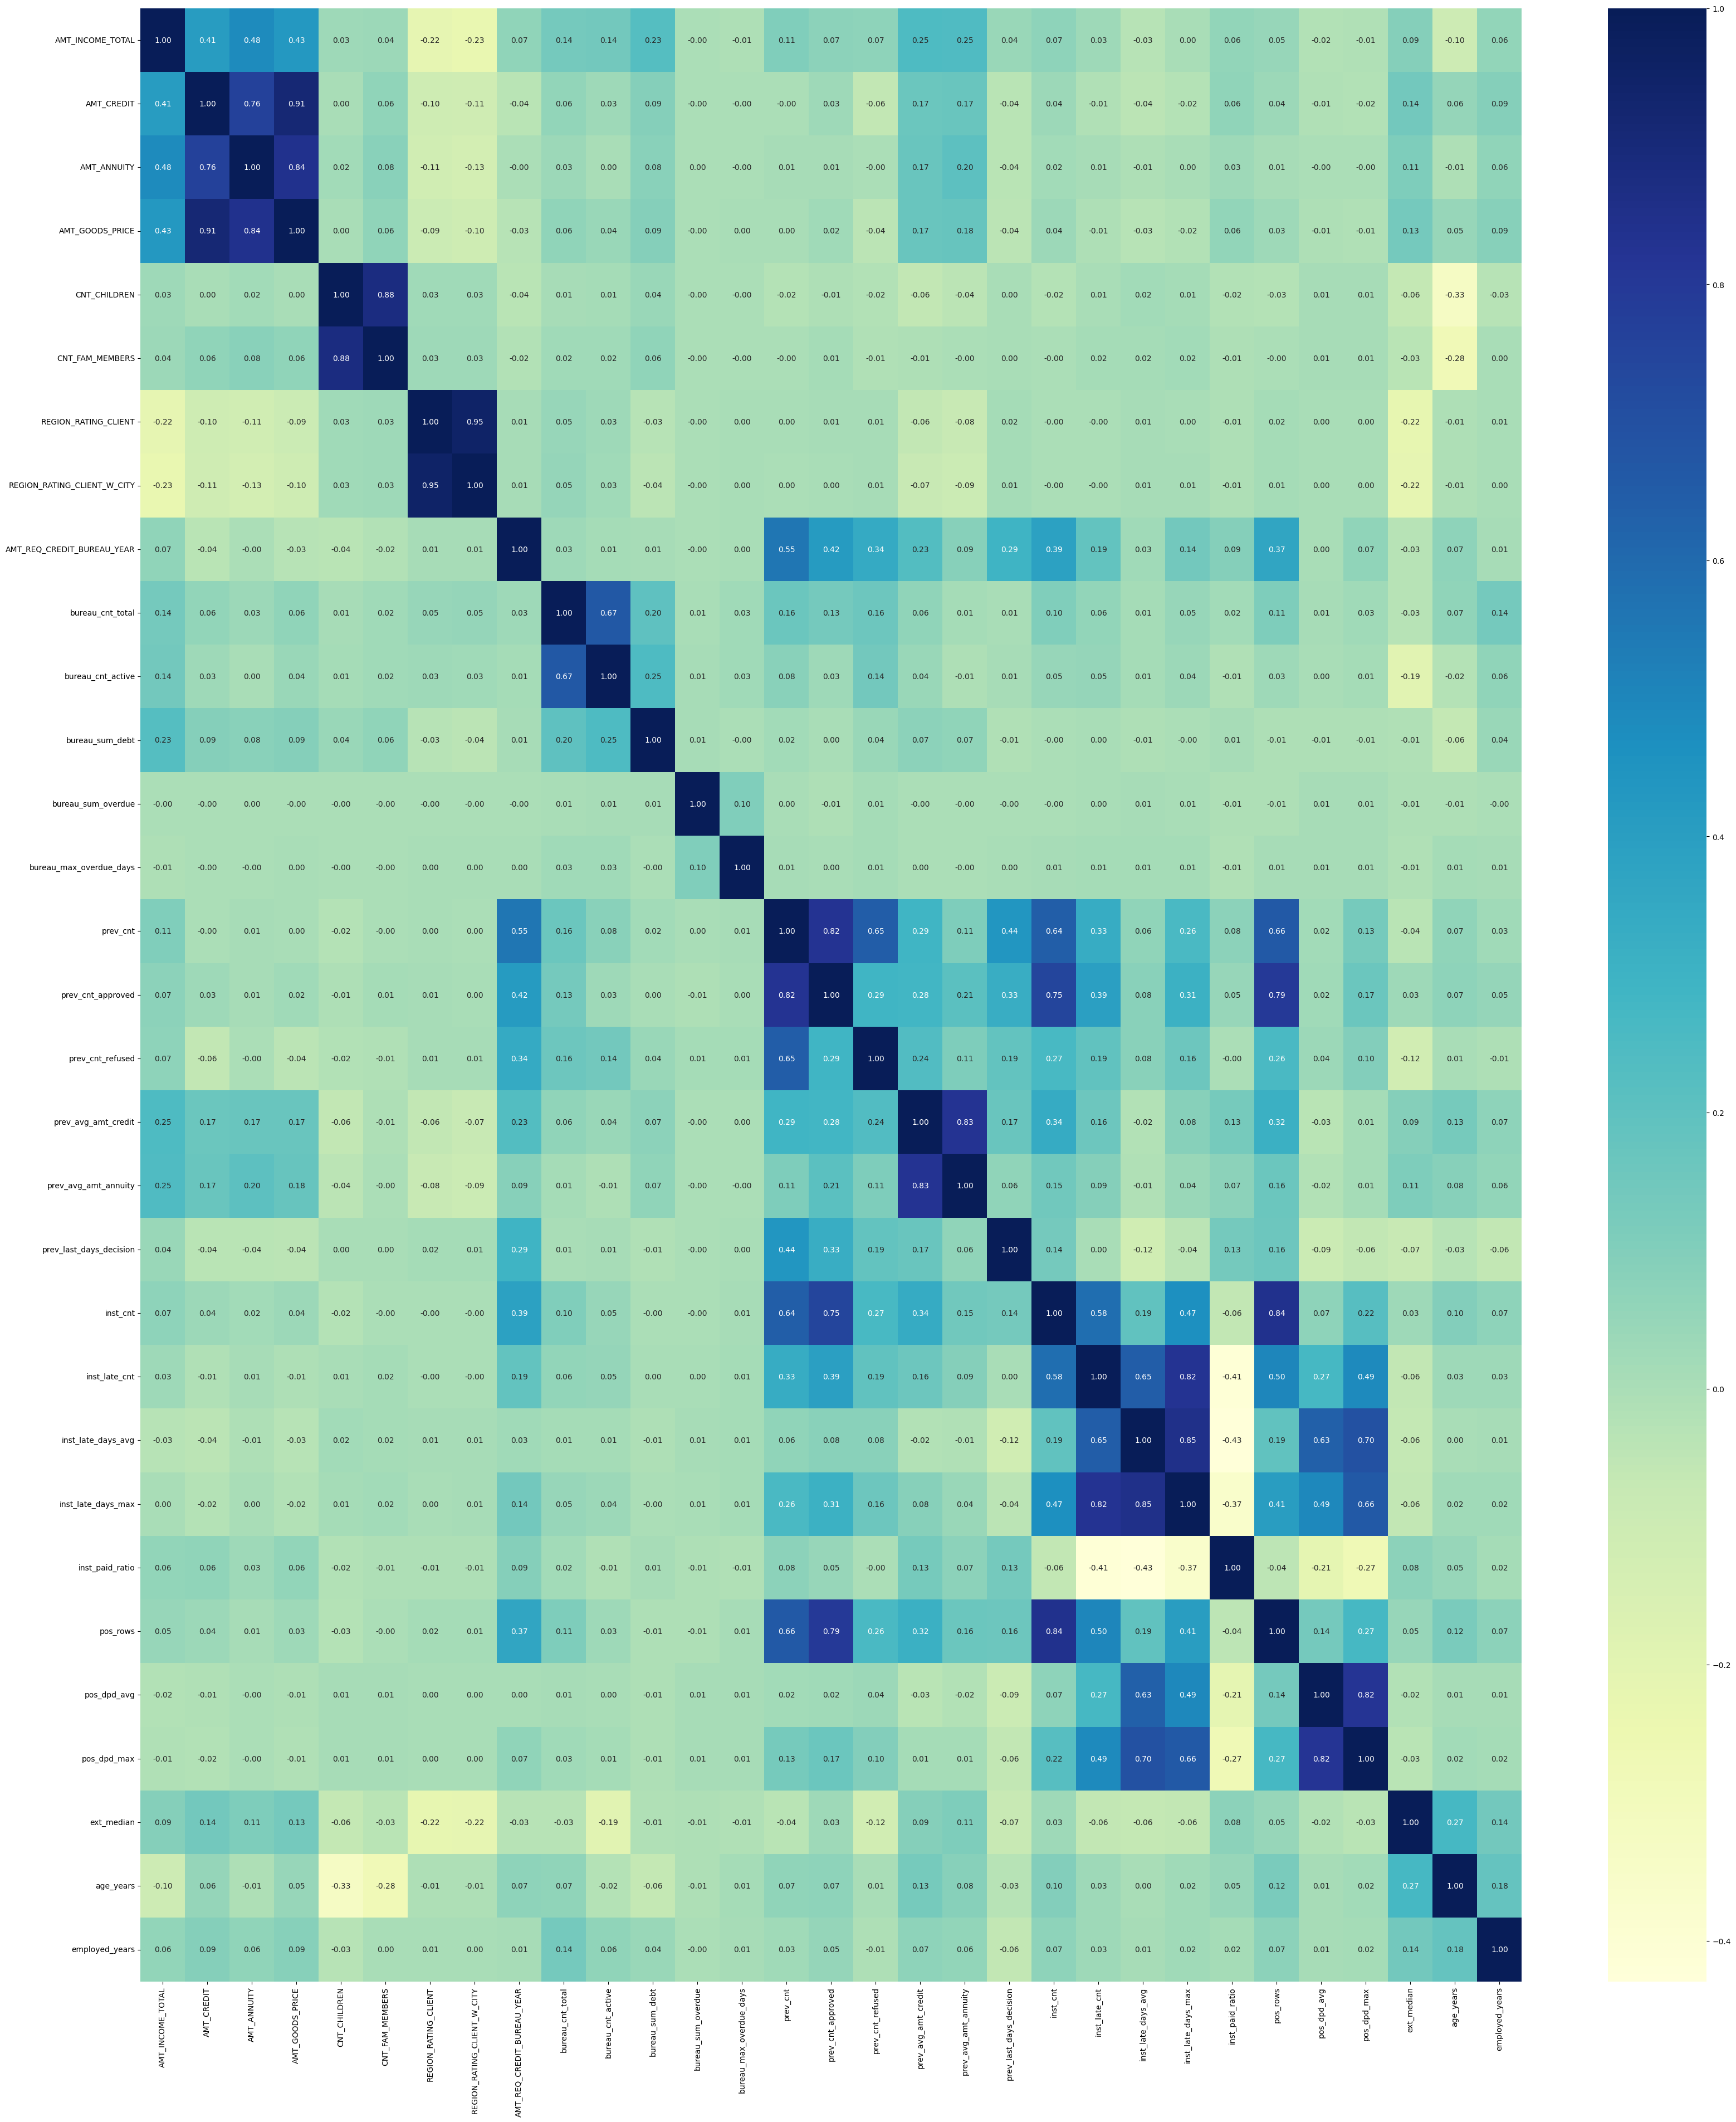

In [ ]:
numeric_columns = df_pretrain.select_dtypes(include=['int64', 'float64']).columns

# correlation heatmap
plt.figure(figsize=(40,46))
correlation = df_pretrain[numeric_columns].corr()
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='YlGnBu')

heatmap terlihat memiliki korelasi yang tinggi dengan kolom lain, sehingga informasinya cenderung “duplikat” dan berpotensi menimbulkan multikolinearitas (khususnya pada model linear seperti Logistic Regression) yang dapat membuat koefisien tidak stabil dan interpretasi model bias. AMT_GOODS_PRICE sangat mirip dengan AMT_CREDIT, sehingga cukup diwakili oleh besaran kredit. REGION_RATING_CLIENT_W_CITY hampir identik dengan REGION_RATING_CLIENT, jadi cukup menyimpan salah satu rating wilayah. CNT_CHILDREN berkorelasi tinggi dengan CNT_FAM_MEMBERS, dan total anggota keluarga sudah merepresentasikan beban tanggungan. Pada riwayat pengajuan, prev_cnt redundan terhadap jumlah approved/refused, sedangkan prev_avg_amt_credit redundan terhadap prev_avg_amt_annuity. Untuk perilaku keterlambatan, inst_late_days_max sangat mirip dengan inst_late_days_avg/inst_late_cnt dan cenderung sensitif outlier, sementara pos_dpd_max juga sangat mirip dengan pos_dpd_avg, sehingga cukup mempertahankan metrik rata-rata yang lebih stabil.

In [ ]:
#drop kolom multikolinearitas

cols_to_drop = [
  "AMT_GOODS_PRICE",
  "REGION_RATING_CLIENT_W_CITY",
  "CNT_CHILDREN",
  "prev_cnt",
  "prev_avg_amt_credit",
  "inst_late_days_max",
  "pos_dpd_max"
]

df_pretrain = df_pretrain.drop(columns=cols_to_drop)
df_test = df_test.drop(columns=cols_to_drop)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 307507 entries, 1 to 356254
Data columns (total 37 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   TARGET                       307507 non-null  object 
 1   AMT_INCOME_TOTAL             307507 non-null  float64
 2   AMT_CREDIT                   307507 non-null  float64
 3   AMT_ANNUITY                  307495 non-null  float64
 4   AMT_GOODS_PRICE              307229 non-null  float64
 5   CODE_GENDER                  307507 non-null  object 
 6   NAME_INCOME_TYPE             307507 non-null  object 
 7   NAME_EDUCATION_TYPE          307507 non-null  object 
 8   CNT_CHILDREN                 307507 non-null  int64  
 9   CNT_FAM_MEMBERS              307505 non-null  float64
 10  FLAG_OWN_CAR                 307507 non-null  object 
 11  FLAG_OWN_REALTY              307507 non-null  object 
 12  REGION_RATING_CLIENT         307507 non-null  int64  
 13  REGI

## **Feature Scalling**

In [ ]:
#OHE Code Gender, flag own car, flag own realty

df_pretrain = pd.get_dummies(df_pretrain, columns=['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY','NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE'], drop_first=False,dtype=int)
df_test = pd.get_dummies(df_test, columns=['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE'], drop_first=False,dtype=int)

In [ ]:
# 2) Samakan kolom test mengikuti train (kategori yang tidak ada di test -> 0)
df_pretrain, df_test = df_pretrain.align(df_test, join="left", axis=1, fill_value=0)

# pastikan urutan kolom sama persis
df_test = df_test[df_pretrain.columns]

In [ ]:
#Ubah nilai aman dan bermasalah dengan 0 dan 1

df_pretrain['TARGET'] = df_pretrain['TARGET'].replace({'Aman': 0, 'Bermasalah': 1})
df_test['TARGET'] = df_test['TARGET'].replace({'Aman': 0, 'Bermasalah': 1})

In [ ]:
#Standar scaller untuk logistic regression modelling

df_pretrain_lr = df_pretrain.copy()
df_test_lr = df_test.copy()

collumns_to_scale = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'AMT_REQ_CREDIT_BUREAU_YEAR',
       'bureau_cnt_total', 'bureau_cnt_active', 'bureau_sum_debt',
       'bureau_sum_overdue', 'bureau_max_overdue_days',
       'prev_cnt_approved', 'prev_cnt_refused',
       'prev_avg_amt_annuity', 'prev_last_days_decision', 'inst_cnt',
       'inst_late_cnt', 'inst_late_days_avg',
       'inst_paid_ratio', 'pos_rows', 'pos_dpd_avg',
       'ext_median', 'age_years', 'employed_years']

scaler = StandardScaler()
df_pretrain_lr[collumns_to_scale] = scaler.fit_transform(df_pretrain[collumns_to_scale])
df_test_lr[collumns_to_scale] = scaler.transform(df_test[collumns_to_scale])

In [ ]:
df_pretrain.head()

TARGET  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  CNT_FAM_MEMBERS  \
280841       1         12.323860    143910.0     9.753188              1.0   
185543       0         12.218500    942300.0    10.228483              1.0   
280346       0         12.660331    460858.5     9.770042              4.0   
35528        0         12.911645    675000.0    10.329817              2.0   
998          0         13.017005   2125953.0    11.303549              1.0   

        REGION_RATING_CLIENT  AMT_REQ_CREDIT_BUREAU_YEAR  bureau_cnt_total  \
280841                     2                         0.0          1.609438   
185543                     2                         3.0          0.693147   
280346                     2                         2.0          1.386294   
35528                      2                         1.0          2.639057   
998                        1                         0.0          1.386294   

        bureau_cnt_active  bureau_sum_debt  bureau_sum_overdue  \
280841           1.386294        295929.06                 0.0   
185543           0.000000             0.00                 0.0   
280346           0.000000             0.00                 0.0   
35528            1.386294       6889324.50                 0.0   
998              1.098612             0.00                 0.0   

        bureau_max_overdue_days  prev_cnt_approved  prev_cnt_refused  \
280841                      0.0           0.693147          1.386294   
185543                      0.0           1.386294          0.693147   
280346                      0.0           1.098612          0.000000   
35528                       0.0           0.693147          0.000000   
998                         0.0           1.386294          0.000000   

        prev_avg_amt_annuity  prev_last_days_decision  inst_cnt  \
280841              9.081558                   -271.0  2.484907   
185543              9.752266                   -582.0  4.007333   
280346             10.330991                   -404.0  3.433987   
35528               8.772539                   -186.0  1.945910   
998                 9.201246                   -300.0  3.218876   

        inst_late_cnt  inst_late_days_avg  inst_paid_ratio  pos_rows  \
280841       1.098612            0.310155         0.646627  2.397895   
185543       2.772589            0.823200         0.671469  3.784190   
280346       0.693147            0.032790         0.693147  3.433987   
35528        0.000000            0.000000         0.693147  1.945910   
998          0.693147            0.028171         0.693147  3.135494   

        pos_dpd_avg  ext_median  age_years  employed_years  CODE_GENDER_F  \
280841     0.000000    0.273096      38.96           14.86              0   
185543     0.110001    0.742436      44.20            8.56              1   
280346     0.000000    0.725276      38.49           13.00              0   
35528      0.000000    0.631027      45.78            4.06              1   
998        0.000000    0.534715      27.71            3.71              0   

        CODE_GENDER_M  FLAG_OWN_CAR_N  FLAG_OWN_CAR_Y  FLAG_OWN_REALTY_N  \
280841              1               1               0                  0   
185543              0               1               0                  1   
280346              1               1               0                  0   
35528               0               0               1                  1   
998                 1               0               1                  1   

        FLAG_OWN_REALTY_Y  NAME_INCOME_TYPE_Businessman  \
280841                  1                             0   
185543                  0                             0   
280346                  1                             0   
35528                   0                             0   
998                     0                             0   

        NAME_INCOME_TYPE_Commercial associate  \
280841                                      0   
185543                         

In [ ]:
df_test.head()

TARGET  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  CNT_FAM_MEMBERS  \
269779       0         11.184435    198666.0     9.661225              4.0   
305320       0         12.307731    247500.0     9.191718              2.0   
42232        0         12.793862    521136.0    10.912467              2.0   
323633       0         12.793862    824917.5    10.592049              2.0   
171980       0         11.813037    628114.5    10.029680              2.0   

        REGION_RATING_CLIENT  AMT_REQ_CREDIT_BUREAU_YEAR  bureau_cnt_total  \
269779                     2                         1.0          1.609438   
305320                     2                         0.0          2.639057   
42232                      1                         1.0          1.609438   
323633                     1                         3.0          2.079442   
171980                     2                         0.0          1.945910   

        bureau_cnt_active  bureau_sum_debt  bureau_sum_overdue  \
269779           1.098612         168763.5                 0.0   
305320           1.791759        7943009.0                 0.0   
42232            1.098612         168763.5                 0.0   
323633           1.386294        3481515.0                 0.0   
171980           1.098612        1131426.0                 0.0   

        bureau_max_overdue_days  prev_cnt_approved  prev_cnt_refused  \
269779                      0.0           1.791759          1.386294   
305320                      0.0           1.386294          0.000000   
42232                       0.0           0.693147          0.000000   
323633                      0.0           0.693147          0.693147   
171980                      0.0           1.098612          0.693147   

        prev_avg_amt_annuity  prev_last_days_decision  inst_cnt  \
269779              8.645446                   -272.0  4.110874   
305320              9.201246                   -300.0  3.218876   
42232               7.747744                   -255.0  2.564949   
323633             10.718243                   -639.0  3.555348   
171980              9.348391                   -773.0  2.564949   

        inst_late_cnt  inst_late_days_avg  inst_paid_ratio  pos_rows  \
269779       1.098612            0.480366         0.741906  4.110874   
305320       0.693147            0.028171         0.693147  3.135494   
42232        1.098612            1.178655         0.605999  2.484907   
323633       1.098612            0.137201         0.677893  3.496508   
171980       1.098612            0.154151         0.693147  2.639057   

        pos_dpd_avg  ext_median  age_years  employed_years  CODE_GENDER_F  \
269779     0.262364    0.294568      25.37            7.12              1   
305320     0.000000    0.587365      29.89            2.22              1   
42232      0.000000    0.643635      27.56            3.49              0   
323633     0.000000    0.553390      51.19           14.11              0   
171980     0.000000    0.567557      49.72           19.37              1   

        CODE_GENDER_M  FLAG_OWN_CAR_N  FLAG_OWN_CAR_Y  FLAG_OWN_REALTY_N  \
269779              0               1               0                  0   
305320              0               1               0                  1   
42232               1               1               0                  1   
323633              1               0               1                  0   
171980              0               1               0                  0   

        FLAG_OWN_REALTY_Y  NAME_INCOME_TYPE_Businessman  \
269779                  1                             0   
305320                  0                             0   
42232                   0                             0   
323633                  1                             0   
171980                  1                             0   

        NAME_INCOME_TYPE_Commercial associate  \
269779                                      0   
305320                         

## **Split Train dan Val**

split untuk modelling logistic regression

In [ ]:
# split data train dan test di modelling logistic regression

X_pretrain_lr = df_pretrain_lr.drop(columns=['TARGET'], axis=1)
y_pretrain_lr = df_pretrain_lr['TARGET']

In [ ]:
X_test_lr = df_test_lr.drop(columns=['TARGET'], axis=1)
y_test_lr = df_test_lr['TARGET']

In [ ]:
#Pisah train sama val

X_train_lr, X_val_lr, y_train_lr, y_val_lr = train_test_split(X_pretrain_lr, y_pretrain_lr, test_size=0.2, random_state=42)

split untuk modelling tree based

In [ ]:
# split data train dan test di modelling tree based model

X_pretrain = df_pretrain.drop(columns=['TARGET'], axis=1)
y_pretrain = df_pretrain['TARGET']

In [ ]:
X_test = df_test.drop(columns=['TARGET'], axis=1)
y_test = df_test['TARGET']

In [ ]:
#pisah train sama val

X_train, X_val, y_train, y_val = train_test_split(X_pretrain, y_pretrain, test_size=0.2, random_state=42)

## **Modelling**

In [ ]:
#Model Building Logistic Regression
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score

# Objective function for Optuna optimization
def objective (trial):
  lr_params = {
      'solver': trial.suggest_categorical('solver', ['liblinear', 'saga', 'newton-cg', 'lbfgs', 'sag', 'newton-cholesky']),
      'random_state': 42,
      'C': trial.suggest_float('C', 0.01, 10, log=True),
      'l1_ratio': trial.suggest_float('l1_ratio', 0.01, 1, log=True),
      'class_weight': trial.suggest_categorical('class_weight', ['balanced', None])
  }

  #Create and train
  lr = LogisticRegression(**lr_params)
  lr.fit(X_train_lr, y_train_lr)

  #Validation
  y_val_log = lr.predict_proba(X_val_lr)[:, 1]
  ap_lr = average_precision_score(y_val_lr, y_val_log)

  return ap_lr

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_params_lr = study.best_params
best_roc_auc_score_lr = study.best_value

# Print the best hyperparameters and corresponding accuracy
print("Best Hyperparameters:", best_params_lr)
print("Best AUPRC:", study.best_value)

[I 2025-12-23 05:21:07,469] A new study created in memory with name: no-name-9e99cc15-b55e-40b7-b56f-61106ae60e0a
[I 2025-12-23 05:21:34,507] Trial 0 finished with value: 0.22358568930776893 and parameters: {'solver': 'saga', 'C': 0.10053565561157699, 'l1_ratio': 0.037134758305245034, 'class_weight': None}. Best is trial 0 with value: 0.22358568930776893.
[I 2025-12-23 05:21:35,349] Trial 1 finished with value: 0.2227172836611255 and parameters: {'solver': 'newton-cholesky', 'C': 0.014025476168003596, 'l1_ratio': 0.036976735549960824, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.22358568930776893.
[I 2025-12-23 05:21:36,244] Trial 2 finished with value: 0.22400747439489715 and parameters: {'solver': 'newton-cholesky', 'C': 1.957828317326291, 'l1_ratio': 0.020260768217836303, 'class_weight': None}. Best is trial 2 with value: 0.22400747439489715.
[I 2025-12-23 05:22:00,197] Trial 3 finished with value: 0.2227070991004832 and parameters: {'solver': 'sag', 'C': 2.59503438185

Best Hyperparameters: {'solver': 'newton-cholesky', 'C': 9.85178788144798, 'l1_ratio': 0.021997486990466174, 'class_weight': None}
Best AUPRC: 0.2243104949015176


In [ ]:
#Model BUilding XGBOOST

from xgboost import XGBClassifier, callback
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score

pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
spw = neg / pos

# Objective function for Optuna optimization
def objective(trial):
    xgb_params = {
        "n_estimators": 5000,
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.05, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 4),
        "min_child_weight": trial.suggest_int("min_child_weight", 10, 40),
        "gamma": trial.suggest_float("gamma", 1.0, 10.0),
        "subsample": trial.suggest_float("subsample", 0.5, 0.8),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 0.9),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 5.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 5.0, 50.0),
        "max_delta_step": trial.suggest_int("max_delta_step", 0, 5),
        "colsample_bynode": trial.suggest_float("colsample_bynode", 0.5, 1.0),
        "scale_pos_weight": spw,
        "random_state": 42,
        "eval_metric": "aucpr",
        "n_jobs": -1,
        "tree_method": "hist"
    }

    # pastikan kolom val urutannya sama
    X_val_aligned = X_val.reindex(columns=X_train.columns, fill_value=float("nan"))


    # early stopping callback dipasang di constructor
    early_stop = callback.EarlyStopping(rounds=100, save_best=True)

    #Create and train
    xgb = XGBClassifier(**xgb_params, callbacks=[early_stop])
    xgb.fit(X_train, y_train,
        eval_set=[(X_val_aligned, y_val)],
        verbose=False)

    #Validation
    y_val_pred = xgb.predict_proba(X_val_aligned)[:, 1]
    ap_xgb = average_precision_score(y_val, y_val_pred)  # AUPRC
    return ap_xgb

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

best_params_xgb = study.best_params
best_ap_xgb = study.best_value

print("Best Hyperparameters:", best_params_xgb)
print("Best AUPRC:", best_ap_xgb)

[I 2025-12-23 05:39:03,956] A new study created in memory with name: no-name-fb6970df-6801-46e2-8de6-19a91abdf99e
[I 2025-12-23 05:42:46,667] Trial 0 finished with value: 0.2363854251398661 and parameters: {'learning_rate': 0.005327576254080428, 'max_depth': 3, 'min_child_weight': 13, 'gamma': 1.9727723516667692, 'subsample': 0.7036427171800352, 'colsample_bytree': 0.8896015887212549, 'reg_alpha': 4.1795862515406075, 'reg_lambda': 33.8159218435629, 'max_delta_step': 5, 'colsample_bynode': 0.8880743482372448}. Best is trial 0 with value: 0.2363854251398661.
[I 2025-12-23 05:45:36,228] Trial 1 finished with value: 0.237201202357187 and parameters: {'learning_rate': 0.008163744093787123, 'max_depth': 4, 'min_child_weight': 35, 'gamma': 3.7986697146614725, 'subsample': 0.7472106764742646, 'colsample_bytree': 0.8206444041593522, 'reg_alpha': 1.8009871295518098, 'reg_lambda': 29.346221723972814, 'max_delta_step': 5, 'colsample_bynode': 0.6963932703032734}. Best is trial 1 with value: 0.23720

Best Hyperparameters: {'learning_rate': 0.03896154592465047, 'max_depth': 4, 'min_child_weight': 36, 'gamma': 7.132102874348103, 'subsample': 0.7171229985562303, 'colsample_bytree': 0.7427025883096483, 'reg_alpha': 4.416276600237231, 'reg_lambda': 43.316323708283065, 'max_delta_step': 1, 'colsample_bynode': 0.8515265880638732}
Best AUPRC: 0.23869667656899812


## **Evaluasi Model**

### **Logistic Regression**

**Before Tuning**

In [ ]:
from sklearn.metrics import precision_recall_curve
# Model Building: Logistic Regression Train before tuning

lr_before = LogisticRegression().fit(X_train_lr, y_train_lr)

y_train_problr_before = lr_before.predict_proba(X_train_lr)[:, 1]
lr_before_auprc_train = average_precision_score(y_train_lr, y_train_problr_before)

print("AUPRC Score (Train):", lr_before_auprc_train)

# THRESHOLD TUNING DI VAL

proba_val = lr_before.predict_proba(X_val_lr)[:, 1]
prec, rec, thr = precision_recall_curve(y_val_lr, proba_val)

f1s = 2*(prec*rec)/(prec+rec+1e-9) #1e-9 cuma untuk komputasi, supaya kalau P=0 dan R=0 tidak jadi NaN.
best_thr_lr = thr[np.argmax(f1s)]

print("Best threshold from val: ", best_thr_lr)


# CLASSIFICATION REPORT TRAIN pakai threshold terbaik

y_train_predlr = (y_train_problr_before >= best_thr_lr).astype(int)

print("Classification Report logistic regression (Train):")
print(classification_report(y_train_lr, y_train_predlr))

AUPRC Score (Train): 0.22636974381687833
Best threshold from val:  0.13309951313052623
Classification Report logistic regression (Train):
              precision    recall  f1-score   support

           0       0.95      0.86      0.90    180947
           1       0.21      0.45      0.29     15857

    accuracy                           0.82    196804
   macro avg       0.58      0.65      0.59    196804
weighted avg       0.89      0.82      0.85    196804



In [ ]:
#model logistic regression test before tuning

# Ensure X_test_lr has the same columns as X_train_lr
X_test_lr_aligned = X_test_lr.reindex(columns=X_train_lr.columns, fill_value=0)

y_test_problr_before = lr_before.predict_proba(X_test_lr_aligned)[:, 1]

#prediksi label pakai best_thr
y_test_predlr_before = (y_test_problr_before >= best_thr_lr).astype(int)

#AUPRC test
lr_before_auprc_test = average_precision_score(y_test_lr, y_test_problr_before)

print("AUPRC Score (Test):", lr_before_auprc_test)

# CLASSIFICATION REPORT TEST
print("Classification Report logistic regression (Test):")
print(classification_report(y_test_lr, y_test_predlr_before))

AUPRC Score (Test): 0.23190498890320077
Classification Report logistic regression (Test):
              precision    recall  f1-score   support

           0       0.95      0.86      0.90     56481
           1       0.22      0.45      0.29      5021

    accuracy                           0.82     61502
   macro avg       0.58      0.65      0.60     61502
weighted avg       0.89      0.82      0.85     61502



**After Tuning**

In [ ]:
# Model Building: Logistic Regression Train after tuning

lr_after = LogisticRegression(**best_params_lr).fit(X_train_lr, y_train_lr)

y_train_problr_after = lr_after.predict_proba(X_train_lr)[:, 1]
lr_after_auprc_train = average_precision_score(y_train_lr, y_train_problr_after)

print("AUPRC Score (Train):", lr_after_auprc_train)

# THRESHOLD TUNING DI VAL

proba_val = lr_after.predict_proba(X_val_lr)[:, 1]
prec, rec, thr = precision_recall_curve(y_val_lr, proba_val)

f1s = 2*(prec*rec)/(prec+rec+1e-9) #1e-9 cuma untuk komputasi, supaya kalau P=0 dan R=0 tidak jadi NaN.
best_thr_lr = thr[np.argmax(f1s)]

print("Best threshold from val: ", best_thr_lr)


# CLASSIFICATION REPORT TRAIN pakai threshold terbaik

y_train_predlr = (y_train_problr_after >= best_thr_lr).astype(int)

print("Classification Report logistic regression (Train):")
print(classification_report(y_train_lr, y_train_predlr))

AUPRC Score (Train): 0.2268763990950044
Best threshold from val:  0.13265391076698646
Classification Report logistic regression (Train):
              precision    recall  f1-score   support

           0       0.95      0.86      0.90    180947
           1       0.21      0.45      0.29     15857

    accuracy                           0.82    196804
   macro avg       0.58      0.65      0.59    196804
weighted avg       0.89      0.82      0.85    196804



In [ ]:
#model logistic regression test after tuning

# Ensure X_test_lr has the same columns as X_train_lr
X_test_lr_aligned = X_test_lr.reindex(columns=X_train_lr.columns, fill_value=0)

y_test_problr_after = lr_after.predict_proba(X_test_lr_aligned)[:, 1]

#prediksi label pakai best_thr
y_test_predlr_after = (y_test_problr_after >= best_thr_lr).astype(int)

#AUPRC test
lr_after_auprc_test = average_precision_score(y_test_lr, y_test_problr_after)

print("AUPRC Score (Test):", lr_after_auprc_test)

# CLASSIFICATION REPORT TEST
print("Classification Report logistic regression (Test):")
print(classification_report(y_test_lr, y_test_predlr_after))

AUPRC Score (Test): 0.23227080343412448
Classification Report logistic regression (Test):
              precision    recall  f1-score   support

           0       0.95      0.86      0.90     56481
           1       0.22      0.45      0.29      5021

    accuracy                           0.82     61502
   macro avg       0.58      0.65      0.60     61502
weighted avg       0.89      0.82      0.85     61502



In [ ]:
#confusion matrix

from sklearn.metrics import confusion_matrix

# Confusion Matrix
cm = confusion_matrix(y_test_lr, y_test_predlr_after)

print(cm)

[[48356  8125]
 [ 2761  2260]]


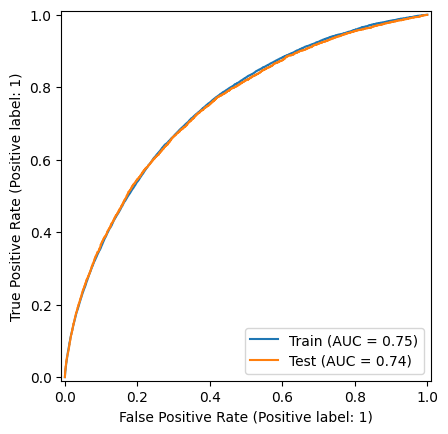

In [ ]:
#curve roc auc train and test after tuning
from sklearn.metrics import RocCurveDisplay

auc_train = RocCurveDisplay.from_estimator(
  lr_after,
  X_train_lr,
  y_train_lr,
  name='Train',
)

# Ensure X_test_lr has the same columns as X_train_lr for plotting
X_test_lr_aligned_for_plot = X_test_lr.reindex(columns=X_train_lr.columns, fill_value=0)

RocCurveDisplay.from_estimator(
  lr_after,
  X_test_lr_aligned_for_plot,
  y_test_lr,
  name='Test',
  ax=auc_train.ax_,
)

### **XGBOOST**

**Before Tuning**

In [ ]:
# Model Building: XGBOOST Train before tuning

xgb_before = XGBClassifier().fit(X_train, y_train)

y_train_probxgb_before = xgb_before.predict_proba(X_train)[:, 1]
xgb_before_auprc_train = average_precision_score(y_train, y_train_probxgb_before)

print("AUPRC Score (Train):", xgb_before_auprc_train)

# THRESHOLD TUNING DI VAL

proba_val = xgb_before.predict_proba(X_val)[:, 1]
prec, rec, thr = precision_recall_curve(y_val, proba_val)

f1s = 2*(prec*rec)/(prec+rec+1e-9) #1e-9 cuma untuk komputasi, supaya kalau P=0 dan R=0 tidak jadi NaN.
best_thr_xgb = thr[np.argmax(f1s)]

print("Best threshold from val:", best_thr_xgb)


# CLASSIFICATION REPORT TRAIN pakai threshold terbaik

y_train_predxgb = (y_train_probxgb_before >= best_thr_xgb).astype(int)

print("Classification Report XGBOOST (Train):")
print(classification_report(y_train, y_train_predxgb))

AUPRC Score (Train): 0.44277834001413596
Best threshold from val: 0.16305496
Classification Report XGBOOST (Train):
              precision    recall  f1-score   support

           0       0.96      0.91      0.93    180947
           1       0.35      0.55      0.43     15857

    accuracy                           0.88    196804
   macro avg       0.66      0.73      0.68    196804
weighted avg       0.91      0.88      0.89    196804



In [ ]:
#model XGBOOST test before tuning
y_test_probxgb_before = xgb_before.predict_proba(X_test)[:, 1]

# prediksi label pakai best_thr (hasil tuning di val)
y_test_predxgb = (y_test_probxgb_before >= best_thr_xgb).astype(int)

# AUPRC test (tetap dari probabilitas)
xgb_before_auprc_test = average_precision_score(y_test, y_test_probxgb_before)
print("AUPRC Score (Test):", xgb_before_auprc_test)

print("Classification Report XGBOOST (Test):")
print(classification_report(y_test, y_test_predxgb))

AUPRC Score (Test): 0.23089691718614103
Classification Report XGBOOST (Test):
              precision    recall  f1-score   support

           0       0.94      0.90      0.92     56481
           1       0.24      0.37      0.29      5021

    accuracy                           0.85     61502
   macro avg       0.59      0.63      0.61     61502
weighted avg       0.88      0.85      0.87     61502



**after tuning**

In [ ]:
#model Xboost train after tuning
from sklearn.metrics import precision_recall_curve

xgb_after = XGBClassifier(**best_params_xgb).fit(X_train, y_train)

y_train_prob = xgb_after.predict_proba(X_train)[:, 1]
xgb_after_auprc_train = average_precision_score(y_train, y_train_prob)

print("AUPRC Score (Train):", xgb_after_auprc_train)

# THRESHOLD TUNING DI VAL

proba_val = xgb_after.predict_proba(X_val)[:, 1]
prec, rec, thr = precision_recall_curve(y_val, proba_val)

f1s = 2*(prec*rec)/(prec+rec+1e-9) #1e-9 cuma untuk komputasi, supaya kalau P=0 dan R=0 tidak jadi NaN.
best_thr = thr[np.argmax(f1s)]

print("Best threshold from val:", best_thr)


# CLASSIFICATION REPORT TRAIN pakai threshold terbaik

y_train_pred = (y_train_prob >= best_thr).astype(int)

print("Classification Report Xgboost (Train):")
print(classification_report(y_train, y_train_pred))

AUPRC Score (Train): 0.23378345101263062
Best threshold from val: 0.1433905
Classification Report Xgboost (Train):
              precision    recall  f1-score   support

           0       0.94      0.88      0.91    180947
           1       0.24      0.41      0.30     15857

    accuracy                           0.85    196804
   macro avg       0.59      0.65      0.61    196804
weighted avg       0.89      0.85      0.86    196804



In [ ]:
#model xgboost test after tuning
y_test_prob = xgb_after.predict_proba(X_test)[:, 1]

# prediksi label pakai best_thr (hasil tuning di val)
y_test_pred = (y_test_prob >= best_thr).astype(int)

# AUPRC test (tetap dari probabilitas)
xgb_after_auprc_test = average_precision_score(y_test, y_test_prob)
print("AUPRC Score (Test):", xgb_after_auprc_test)

print("Classification Report Xgboost (Test):")
print(classification_report(y_test, y_test_pred))

AUPRC Score (Test): 0.236420523474331
Classification Report Xgboost (Test):
              precision    recall  f1-score   support

           0       0.94      0.88      0.91     56481
           1       0.24      0.41      0.30      5021

    accuracy                           0.84     61502
   macro avg       0.59      0.65      0.61     61502
weighted avg       0.89      0.84      0.86     61502



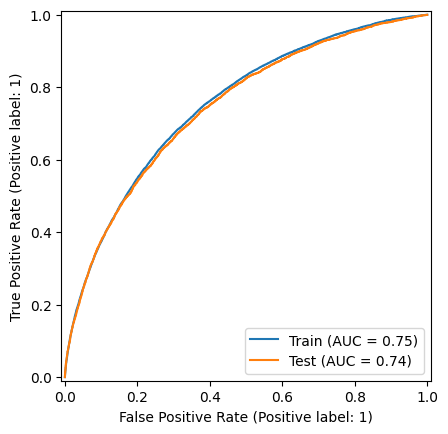

In [ ]:
#curve roc auc train and test after tuning
from sklearn.metrics import RocCurveDisplay

auc_train = RocCurveDisplay.from_estimator(
  xgb_after,
  X_train,
  y_train,
  name='Train',
)

RocCurveDisplay.from_estimator(
  xgb_after,
  X_test,
  y_test,
  name='Test',
  ax=auc_train.ax_,
)

In [ ]:
#confusion matrix xgb

from sklearn.metrics import confusion_matrix

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)

print(cm)

[[49926  6555]
 [ 2980  2041]]


- Based on the highest test AUPRC (0.2364) and improved generalization after tuning, XGBoost was selected as the best-performing model for this project.
- AUPRC = 0.2364 exceeds the baseline (~0.08). For TARGET=1, recall = 0.41 and precision = 0.24, indicating that the model is suitable for early screening and manual review, rather than auto-rejection.
- ROC-AUC is stable with 0.75 (train) and 0.74 (test), indicating no strong overfitting.
- The confusion matrix shows that most safe borrowers are predicted correctly. Still, some are predicted as risky, increasing reviews and reducing approvals. In contrast, some risky borrowers are missed, increasing default loss, so a risk-tier policy with manual review for high-risk cases is recommended.

## **Feature Importance**

In [ ]:
# Initialize Explainer for all models

## initiate explainer for XGBoost model
default_xgb_exp = dx.Explainer(xgb_after, X_train, y_train, label="XGBoost Interpretation")

Preparation of a new explainer is initiated

  -> data              : 196804 rows 43 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 196804 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : XGBoost Interpretation
  -> predict function  : <function yhat_proba_default at 0x7cc926d5a160> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0159, mean = 0.0806, max = 0.448
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.438, mean = 8.32e-06, max = 0.982
  -> model_info        : package xgboost

A new explainer has been created!


In [ ]:
# visualize permutation feature importance for XGBoost model
default_xgb_exp.model_parts().plot()

In [ ]:
# create partial dependence plot of XGBoost model
default_xgb_exp.model_profile().plot()

Calculating ceteris paribus: 100%|██████████| 43/43 [00:09<00:00,  4.63it/s]


- The most important driver is ext_median, meaning external risk scores provide the strongest signal for predicting payment difficulty.

- The partial dependence plot shows a clear pattern: when ext_median rises from ~0.10 s/d 0.20 to ~0.60 s/d 0.70, the predicted risk drops sharply and then becomes nearly flat above ~0.70, meaning low ext_median (<0.30) is associated with much higher default risk.

- Other meaningful contributors include employment length (employed_years), credit history activity (pos_rows, bureau_sum_debt), and repayment behavior (inst_late_days_avg, prev_cnt_refused), which together reflect stability and past credit performance.

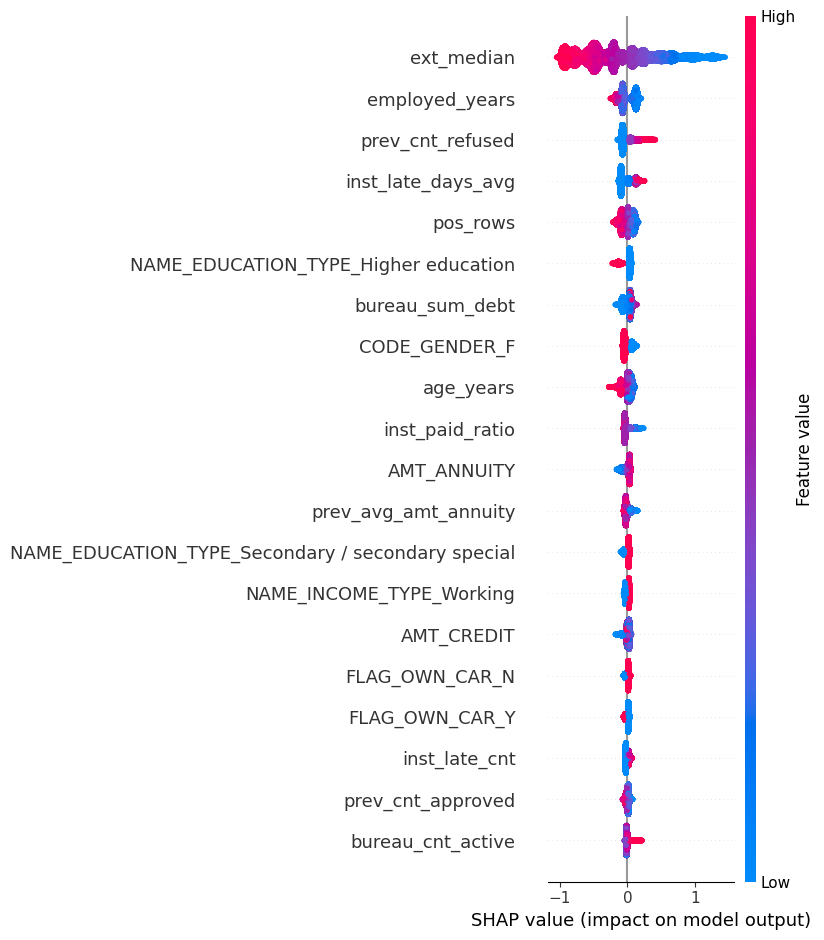

In [ ]:
import xgboost # Ensure xgboost is imported

# Convert X_train columns to a list for feature_names
dtrain = xgboost.DMatrix(X_train, feature_names=list(getattr(X_train, 'columns', None)))
booster = xgb_after.get_booster()

contribs = booster.predict(dtrain, pred_contribs=True, approx_contribs=False)
shap_values = contribs[:, :-1]      # (n_samples, n_features)
expected_values = contribs[:, -1]   # (n_samples,)

exp = shap.Explanation(
    values=shap_values,
    base_values=expected_values,
    data=np.array(X_train),
    feature_names=list(getattr(X_train,'columns', map(str, range(shap_values.shape[1]))))
)
shap.summary_plot(exp.values, exp.data, feature_names=exp.feature_names)

**Rekomendasi:**

1. Pakai model untuk menyaring risiko saat underwriting. Gunakan skor risiko sebagai alat bantu, lalu bagi nasabah menjadi 3 level: risiko rendah (proses cepat), risiko sedang (verifikasi standar), risiko tinggi (verifikasi tambahan dan review manual).
2. Terapkan mitigasi pada faktor risiko utama Karena ext_median paling kuat dan nilai yang lebih rendah berarti risiko lebih tinggi, nasabah dengan ext_median rendah bisa diberi kebijakan seperti plafon lebih kecil, tenor lebih pendek, dan verifikasi penghasilan/dokumen lebih ketat.
3. Jangan auto-reject, gunakan untuk prioritas pengecekan, Karena precision masih rendah, prediksi “berisiko” sebaiknya dipakai untuk menentukan siapa yang perlu pemeriksaan tambahan agar approval rate tidak turun tajam.
4. Atur threshold sesuai biaya dan kebijakan risiko. Jika fokus utama menekan kredit macet, pilih threshold yang menangkap lebih banyak kasus berisiko. Jika kapasitas review terbatas, pilih threshold yang mengurangi pengecekan berlebih.